# Telecom Churn Case Study

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
For many incumbent operators, retaining high profitable customers is the number one business goal.
To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).
In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.
However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).
Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.
This project is based on the Indian and Southeast Asian market.
There are various ways to define churn, such as:
Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.
The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.
Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.
A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.
In this project, we will use the usage-based definition to define churn.
In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. 

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :
The ‘good’ phase (June and July): In this phase, the customer is happy with the service and behaves as usual.
The ‘action’ phase (August): The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)
The ‘churn’ phase (September): In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.
    


In [369]:
# Import the required libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.filterwarnings('ignore')

## Step 01 - Reading and Understanding the data

In [370]:
# Read the telecom churn dataset
telecom_data = pd.read_csv('telecom_churn_data.csv')
telecom_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [371]:
# Check the shape of dataset
telecom_data.shape

(99999, 226)

In [372]:
# There are many columns in the dataset. We'll first try to identify if all the columns have required values.
telecom_null_col = ((telecom_data.isnull().sum() * 100 / len(telecom_data.index)).to_frame('null')).sort_values('null', ascending=False)

In [373]:
telecom_null_col

,null
arpu_3g_6,74.846748
night_pck_user_6,74.846748
total_rech_data_6,74.846748
arpu_2g_6,74.846748
max_rech_data_6,74.846748
...,...
max_rech_amt_7,0.000000
max_rech_amt_6,0.000000
total_rech_amt_9,0.000000
total_rech_amt_8,0.000000


### Step 1.1 - Null value treatment

In [374]:
# We'll look to remove such columns which have null values more than 30%
telecom_null_col_list = list(telecom_null_col.index[telecom_null_col['null'] > 30])

In [375]:
telecom_null_col_list

['arpu_3g_6',
 'night_pck_user_6',
 'total_rech_data_6',
 'arpu_2g_6',
 'max_rech_data_6',
 'fb_user_6',
 'av_rech_amt_data_6',
 'date_of_last_rech_data_6',
 'count_rech_2g_6',
 'count_rech_3g_6',
 'date_of_last_rech_data_7',
 'total_rech_data_7',
 'fb_user_7',
 'max_rech_data_7',
 'night_pck_user_7',
 'count_rech_2g_7',
 'av_rech_amt_data_7',
 'arpu_2g_7',
 'count_rech_3g_7',
 'arpu_3g_7',
 'total_rech_data_9',
 'count_rech_3g_9',
 'fb_user_9',
 'max_rech_data_9',
 'arpu_3g_9',
 'date_of_last_rech_data_9',
 'night_pck_user_9',
 'arpu_2g_9',
 'count_rech_2g_9',
 'av_rech_amt_data_9',
 'total_rech_data_8',
 'arpu_3g_8',
 'fb_user_8',
 'night_pck_user_8',
 'av_rech_amt_data_8',
 'max_rech_data_8',
 'count_rech_3g_8',
 'arpu_2g_8',
 'count_rech_2g_8',
 'date_of_last_rech_data_8']

In [376]:
telecom_data = telecom_data.drop(telecom_null_col_list, axis = 1)

In [377]:
telecom_data.shape

(99999, 186)

In [378]:
# We'll now look to filter high value customers by averaging total recharge amount for month 6 and 7.
telecom_data['rech_mnth_6_7_avg'] = (telecom_data['total_rech_amt_6'] + telecom_data['total_rech_amt_7']) / 2

In [379]:
# We'll find 70th percentile of this average amount and use that amount to find high value customers
X = telecom_data['rech_mnth_6_7_avg'].quantile(0.7)
X

368.5

In [380]:
# Since the prediction needs to happen only for high value customers, we'll keep only relevant information for high value customers.
telecom_data = telecom_data[telecom_data.rech_mnth_6_7_avg >= X]

In [381]:
telecom_data.shape

(30011, 187)

We're left with 30k high value customer records for prediction now.

In [382]:
# We'll now look for rows which hs more than 50% of null value columns
null_cols = telecom_data[(telecom_data.isnull().sum(axis=1)) > len(telecom_data.columns)//2]

In [383]:
null_cols

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg
2185,7000237332,109,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,9/30/2014,386.514,386.506,386.491,386.493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,2,4,455,455,455,455,455,455,455,455,6/25/2014,7/23/2014,8/22/2014,9/26/2014,455,455,455,0,3.65,71.00,11.73,9.97,285.63,2316.13,1429.59,1205.97,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,882,172.71,657.55,9.22,0.0,455.0
3506,7002324263,109,NaN,NaN,NaN,6/30/2014,NaN,NaN,NaN,996.558,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [384]:
telecom_data = telecom_data.drop(null_cols.index)

In [385]:
telecom_data.shape

(29897, 187)

In [386]:
# Let's check null values for columns again
telecom_null_col = (round((telecom_data.isnull().sum() * 100 / len(telecom_data.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [387]:
telecom_null_col

,null
loc_og_t2m_mou_9,5.32
loc_ic_t2f_mou_9,5.32
roam_og_mou_9,5.32
loc_og_t2t_mou_9,5.32
std_ic_t2m_mou_9,5.32
...,...
max_rech_amt_6,0.00
max_rech_amt_7,0.00
max_rech_amt_8,0.00
max_rech_amt_9,0.00


In [388]:
# Looks like fields with mou_9 have null values in same records as the null percentage is exactly same.
telecom_null_col[telecom_null_col.null == 5.32]

,null
loc_og_t2m_mou_9,5.32
loc_ic_t2f_mou_9,5.32
roam_og_mou_9,5.32
loc_og_t2t_mou_9,5.32
std_ic_t2m_mou_9,5.32
std_ic_t2t_mou_9,5.32
loc_og_t2f_mou_9,5.32
loc_og_t2c_mou_9,5.32
loc_ic_mou_9,5.32
loc_og_mou_9,5.32


In [389]:
# Let's validate the above by getting Null condition on only one field and chacke for other mou_9 fiields
mou_9_null_val = telecom_data[telecom_data.loc_og_t2m_mou_9.isnull()]

In [390]:
mou_9_null_val


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,1349.850,3171.480,500.0,57.84,54.68,52.29,NaN,453.43,567.16,325.91,NaN,16.23,33.49,31.64,NaN,23.74,12.59,38.06,NaN,51.39,31.38,40.28,NaN,308.63,447.38,162.28,NaN,62.13,55.14,53.23,NaN,0.00,0.00,0.0,NaN,422.16,533.91,255.79,NaN,4.30,23.29,12.01,NaN,49.89,31.76,49.14,NaN,6.66,20.08,16.68,NaN,0.0,0.0,0.0,NaN,60.86,75.14,77.84,NaN,0.00,0.18,10.01,NaN,4.50,0.00,6.50,NaN,0.00,0.0,0.0,NaN,487.53,609.24,350.16,0.0,58.14,32.26,27.31,NaN,217.56,221.49,121.19,NaN,152.16,101.46,39.53,NaN,427.88,355.23,188.04,NaN,36.89,11.83,30.39,NaN,91.44,126.99,141.33,NaN,52.19,34.24,22.21,NaN,0.0,0.0,0.0,NaN,180.54,173.08,193.94,NaN,626.46,558.04,428.74,0.0,0.21,0.0,0.00,NaN,2.06,14.53,31.59,NaN,15.74,15.19,15.14,NaN,5,5,7,3,1580,790,3638,0,1580,790,1580,0,6/27/2014,7/25/2014,8/26/2014,9/30/2014,0,0,779,0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.0,1185.0
97,7000589828,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,374.863,294.023,183.043,0.0,433.59,415.66,221.06,NaN,74.54,43.66,31.86,NaN,0.00,0.00,6.16,NaN,0.00,0.00,23.91,NaN,2.83,16.19,9.73,NaN,16.99,23.14,17.79,NaN,3.54,1.46,1.83,NaN,0.40,0.00,0.0,NaN,23.38,4

In [391]:
mou_9_null_col = (round((mou_9_null_val.isnull().sum() * 100 / len(mou_9_null_val.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [392]:
mou_9_null_col

,null
isd_og_mou_9,100.0
loc_og_mou_9,100.0
std_og_t2t_mou_9,100.0
roam_ic_mou_9,100.0
loc_ic_mou_9,100.0
...,...
max_rech_amt_6,0.0
max_rech_amt_7,0.0
max_rech_amt_8,0.0
max_rech_amt_9,0.0


In [393]:
mou_9_null_col[mou_9_null_col.null == 100]

,null
isd_og_mou_9,100.0
loc_og_mou_9,100.0
std_og_t2t_mou_9,100.0
roam_ic_mou_9,100.0
loc_ic_mou_9,100.0
std_ic_t2o_mou_9,100.0
roam_og_mou_9,100.0
loc_ic_t2t_mou_9,100.0
loc_og_t2t_mou_9,100.0
spl_ic_mou_9,100.0


In [394]:
# We'll drop these rows as well
telecom_data = telecom_data.drop(mou_9_null_val.index)

In [395]:
telecom_data.shape

(28307, 187)

In [396]:
# Let's check null values for columns again
telecom_null_col = (round((telecom_data.isnull().sum() * 100 / len(telecom_data.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [397]:
telecom_null_col

,null
date_of_last_rech_8,1.08
date_of_last_rech_9,1.04
loc_og_mou_8,0.55
std_og_t2m_mou_8,0.55
roam_ic_mou_8,0.55
...,...
total_og_mou_7,0.00
total_og_mou_6,0.00
og_others_9,0.00
spl_og_mou_9,0.00


In [398]:
telecom_null_col[telecom_null_col.null == 0.55]

,null
loc_og_mou_8,0.55
std_og_t2m_mou_8,0.55
roam_ic_mou_8,0.55
std_og_t2t_mou_8,0.55
loc_ic_t2m_mou_8,0.55
roam_og_mou_8,0.55
loc_ic_t2t_mou_8,0.55
og_others_8,0.55
loc_og_t2t_mou_8,0.55
spl_og_mou_8,0.55


In [399]:
# Looks like mou_8 fields have similar missing values. # Let's validate the above by getting Null condition on only one field and chacke for other mou_8 fiields
mou_8_null_val = telecom_data[telecom_data.loc_og_mou_8.isnull()]


In [400]:
mou_8_null_val

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg
375,7002252754,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,580.477,111.878,0.0,378.881,249.43,39.64,NaN,245.06,62.24,37.24,NaN,144.53,25.49,19.43,NaN,0.00,312.59,78.58,NaN,0.00,0.00,0.00,NaN,11.54,0.00,0.00,NaN,25.31,0.00,0.00,NaN,0.0,0.00,0.0,NaN,0.41,0.00,0.00,NaN,36.86,0.00,0.00,NaN,233.51,0.00,0.00,NaN,118.79,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.00,0.00,NaN,352.31,0.0,0.0,NaN,0.0,0.00,0.00,NaN,4.78,0.00,0.0,NaN,0.0,0.00,0.00,0.0,393.96,0.00,0.00,NaN,6.74,0.00,0.00,NaN,38.53,0.00,0.00,NaN,0.0,0.00,0.00,NaN,45.28,0.00,0.00,NaN,8.31,0.00,0.00,NaN,27.31,0.00,0.00,NaN,0.0,0.0,0.0,NaN,0.0,0.00,0.00,NaN,35.63,0.00,0.00,0.0,80.91,0.00,0.0,NaN,0.00,0.00,0.00,NaN,0.00,0.00,0.0,NaN,0.0,17,6,3,11,700,130,0,440,80,50,0,50,6/26/2014,7/23/2014,8/15/2014,9/30/2014,30,0,0,30,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1102,0.0,0.00,0.00,0.00,415.0
578,7000248548,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,569.612,237.289,0.0,4.440,718.01,212.73,NaN,0.00,487.06,139.71,NaN,1.26,0.00,2.01,NaN,6.43,0.00,6.30,NaN,1.26,11.28,27.89,NaN,0.00,42.24,46.94,NaN,0.00,0.00,0.00,NaN,0.0,2.33,0.0,NaN,0.00,53.53,74.84,NaN,0.00,706.73,178.53,NaN,0.00,442.48,92.76,NaN,0.00,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,114

In [401]:
mou_8_null_col = (round((mou_8_null_val.isnull().sum() * 100 / len(mou_8_null_val.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [402]:
mou_8_null_col

,null
ic_others_8,100.0
loc_og_mou_8,100.0
roam_og_mou_8,100.0
loc_og_t2t_mou_8,100.0
std_ic_t2t_mou_8,100.0
...,...
total_og_mou_7,0.0
total_og_mou_6,0.0
og_others_9,0.0
spl_og_mou_9,0.0


In [403]:
mou_8_null_col[mou_8_null_col.null == 100]

,null
ic_others_8,100.0
loc_og_mou_8,100.0
roam_og_mou_8,100.0
loc_og_t2t_mou_8,100.0
std_ic_t2t_mou_8,100.0
loc_og_t2m_mou_8,100.0
loc_ic_mou_8,100.0
loc_og_t2f_mou_8,100.0
loc_og_t2c_mou_8,100.0
loc_ic_t2f_mou_8,100.0


In [404]:
# We'll drop these rows as well
telecom_data = telecom_data.drop(mou_8_null_val.index)

In [405]:
telecom_data.shape

(28150, 187)

In [406]:
# Let's check null values for columns again
telecom_null_col = (round((telecom_data.isnull().sum() * 100 / len(telecom_data.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [407]:
telecom_null_col

,null
date_of_last_rech_9,1.02
date_of_last_rech_8,1.01
loc_og_t2t_mou_6,0.44
loc_og_t2f_mou_6,0.44
loc_og_t2c_mou_6,0.44
...,...
std_og_mou_8,0.00
std_og_t2c_mou_9,0.00
std_og_t2c_mou_8,0.00
std_og_t2f_mou_9,0.00


In [408]:
telecom_null_col[telecom_null_col.null == 0.44]

,null
loc_og_t2t_mou_6,0.44
loc_og_t2f_mou_6,0.44
loc_og_t2c_mou_6,0.44
loc_og_mou_6,0.44
std_og_t2t_mou_6,0.44
std_og_t2m_mou_6,0.44
std_og_t2f_mou_6,0.44
std_og_t2c_mou_6,0.44
std_og_mou_6,0.44
isd_og_mou_6,0.44


In [409]:
# Looks like mou_6 fields have similar missing values. # Let's validate the above by getting Null condition on only one field and chacke for other mou_6 fiields
mou_6_null_val = telecom_data[telecom_data.loc_og_t2t_mou_6.isnull()]


In [410]:
mou_6_null_val

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg
77,7001328263,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,30.000,82.378,674.950,158.710,NaN,34.23,149.69,6.31,NaN,39.44,179.18,57.68,NaN,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN,34.23,149.69,6.31,NaN,32.18,101.63,29.41,NaN,0.91,29.86,28.26,NaN,0.00,3.90,0.00,NaN,67.33,281.19,63.99,NaN,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN,6.35,40.09,0.00,NaN,0.0,0.0,0.0,NaN,6.35,40.09,0.00,NaN,2.93,28.04,3.25,NaN,0.00,7.58,0.00,NaN,0.0,0.0,0.0,0.0,76.61,356.93,67.24,NaN,79.46,191.24,5.26,NaN,43.31,94.18,16.39,NaN,2.03,0.00,15.78,NaN,124.81,285.43,37.44,NaN,8.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN,0.00,0.00,15.93,NaN,0.0,0.0,0.0,NaN,8.00,0.00,15.93,0.0,135.38,289.33,53.38,NaN,0.0,0.00,0.00,NaN,2.56,0.50,0.00,NaN,0.00,3.39,0.00,4,5,3,3,0,1154,750,0,0,1000,750,0,6/17/2014,7/27/2014,8/27/2014,9/24/2014,0,0,750,0,0.0,96.48,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1894,0.00,0.00,0.00,0.00,577.0
364,7002168045,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.000,792.112,989.368,923.040,NaN,433.49,198.96,571.99,NaN,845.11,923.58,828.29,NaN,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN,28.78,7.46,64.73,NaN,78.78,584.76,490.71,NaN,21.58,9.43,0.00,NaN,0.00,0.00,2.78,NaN,129.14,601.66,555.44,NaN,404.71,191.49,507.26,NaN,7

In [411]:
mou_6_null_col = (round((mou_6_null_val.isnull().sum() * 100 / len(mou_6_null_val.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [412]:
mou_6_null_col

,null
loc_ic_t2f_mou_6,100.0
ic_others_6,100.0
std_og_t2t_mou_6,100.0
roam_og_mou_6,100.0
loc_ic_t2t_mou_6,100.0
...,...
std_og_mou_8,0.0
std_og_t2c_mou_9,0.0
std_og_t2c_mou_8,0.0
std_og_t2f_mou_9,0.0


In [413]:
mou_6_null_col[mou_6_null_col.null == 100]

,null
loc_ic_t2f_mou_6,100.0
ic_others_6,100.0
std_og_t2t_mou_6,100.0
roam_og_mou_6,100.0
loc_ic_t2t_mou_6,100.0
loc_og_t2t_mou_6,100.0
og_others_6,100.0
spl_og_mou_6,100.0
loc_og_t2m_mou_6,100.0
isd_og_mou_6,100.0


In [414]:
# We'll drop these rows as well
telecom_data = telecom_data.drop(mou_6_null_val.index)

In [415]:
telecom_data.shape

(28026, 187)

In [416]:
# Let's check null values for columns again
telecom_null_col = (round((telecom_data.isnull().sum() * 100 / len(telecom_data.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [417]:
telecom_null_col

,null
date_of_last_rech_9,1.02
date_of_last_rech_8,1.01
date_of_last_rech_7,0.20
og_others_7,0.12
spl_ic_mou_7,0.12
...,...
isd_og_mou_8,0.00
isd_og_mou_9,0.00
spl_og_mou_6,0.00
spl_og_mou_8,0.00


In [418]:
telecom_null_col[telecom_null_col.null == 0.12]

,null
og_others_7,0.12
spl_ic_mou_7,0.12
loc_og_t2m_mou_7,0.12
spl_og_mou_7,0.12
loc_og_t2f_mou_7,0.12
isd_ic_mou_7,0.12
isd_og_mou_7,0.12
loc_og_t2c_mou_7,0.12
std_ic_t2m_mou_7,0.12
roam_ic_mou_7,0.12


In [419]:
# Looks like mou_7 fields have similar missing values. # Let's validate the above by getting Null condition on only one field and check for other mou_7 fiields
mou_7_null_val = telecom_data[telecom_data.og_others_7.isnull()]
mou_7_null_val

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg
5616,7001238202,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,760.815,531.088,992.818,1144.676,324.91,NaN,386.13,1180.29,350.29,NaN,399.64,887.76,463.63,NaN,221.46,0.00,505.71,NaN,175.93,0.00,145.91,NaN,243.43,1108.38,0.85,NaN,184.78,300.19,1.13,NaN,7.94,67.11,0.00,NaN,12.51,18.89,147.89,NaN,436.16,1475.69,0.96,NaN,17.06,69.51,15.91,NaN,144.04,490.61,0.00,NaN,0.00,13.33,0.0,NaN,0.0,0.0,16.88,NaN,161.11,573.46,0.00,NaN,0.00,0.00,4.71,NaN,12.56,18.89,0.00,NaN,0.0,0.0,169.49,0.0,609.84,2068.06,78.76,NaN,233.66,558.84,1.36,NaN,11.53,75.31,6.61,NaN,0.00,31.81,86.74,NaN,245.19,665.98,0.00,NaN,12.13,42.39,21.76,NaN,110.99,263.98,0.00,NaN,0.00,6.43,0.0,NaN,0.0,0.0,21.76,NaN,123.13,312.81,189.81,0.0,397.13,1020.16,0.00,NaN,0.00,0.13,81.29,NaN,28.79,41.23,0.00,NaN,0.00,0.00,5,7,9,13,776,780,904,1591,250,330,200,289,6/17/2014,7/30/2014,8/27/2014,9/30/2014,250,0,130,250,0.00,0.00,11.26,83.32,0.00,0.00,79.94,668.40,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,576,63.38,0.00,0.00,163.39,778.0
9451,7001477649,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1129.566,0.000,128.252,802.648,11.89,NaN,1.46,33.89,259.18,NaN,26.21,241.18,9.98,NaN,1.73,0.00,5.66,NaN,2.46,0.00,6.73,NaN,1.46,20.84,171.46,NaN,20.54,148.88,0.00,NaN,0.00,0.00,

In [420]:
mou_7_null_col = (round((mou_7_null_val.isnull().sum() * 100 / len(mou_7_null_val.index)),2).to_frame('null')).sort_values('null', ascending=False)
mou_7_null_col

,null
std_ic_t2m_mou_7,100.0
loc_og_t2c_mou_7,100.0
loc_og_t2f_mou_7,100.0
loc_ic_t2t_mou_7,100.0
ic_others_7,100.0
...,...
isd_og_mou_8,0.0
isd_og_mou_9,0.0
spl_og_mou_6,0.0
spl_og_mou_8,0.0


In [421]:
mou_7_null_col[mou_7_null_col.null == 100]

,null
std_ic_t2m_mou_7,100.0
loc_og_t2c_mou_7,100.0
loc_og_t2f_mou_7,100.0
loc_ic_t2t_mou_7,100.0
ic_others_7,100.0
roam_ic_mou_7,100.0
loc_og_mou_7,100.0
roam_og_mou_7,100.0
std_og_t2f_mou_7,100.0
std_og_mou_7,100.0


In [422]:
# We'll drop these rows as well
telecom_data = telecom_data.drop(mou_7_null_val.index)

In [423]:
telecom_data.shape

(27991, 187)

In [424]:
# Let's check null values for columns again
telecom_null_col = (round((telecom_data.isnull().sum() * 100 / len(telecom_data.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [425]:
telecom_null_col

,null
date_of_last_rech_9,1.02
date_of_last_rech_8,1.01
date_of_last_rech_7,0.20
date_of_last_rech_6,0.10
std_ic_mou_9,0.00
...,...
std_og_t2c_mou_9,0.00
std_og_mou_6,0.00
std_og_mou_7,0.00
std_og_mou_8,0.00


In [426]:
# We can see that there are only 4 columns with very low null value percentage. We can remove these as well
pending_null = telecom_data[(telecom_data.date_of_last_rech_6.isnull())
                           | (telecom_data.date_of_last_rech_7.isnull())
                           | (telecom_data.date_of_last_rech_8.isnull())
                           | (telecom_data.date_of_last_rech_9.isnull())]

In [427]:
pending_null


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg
191,7000608224,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,213.833,618.449,0.000,213.786,0.00,169.34,0.00,0.00,0.00,302.33,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,31.01,0.00,0.00,0.00,102.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.79,0.00,0.00,0.00,138.33,0.00,0.00,0.00,199.54,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,337.88,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,471.68,0.00,0.00,2.73,21.28,13.89,0.96,15.13,22.06,18.93,17.93,2.90,0.00,29.53,0.00,20.76,43.34,62.36,18.89,0.81,100.38,0.41,0.00,29.28,42.93,24.09,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,30.09,143.31,24.51,0.00,51.01,222.34,171.38,18.89,0.00,0.31,0.00,0.00,0.00,35.36,84.44,0.00,0.14,0.00,0.05,0.00,2,5,0,2,252,729,0,252,252,252,0,252,6/12/2014,7/30/2014,NaN,9/30/2014,0,252,0,252,2.62,10.87,0.00,0.00,995.57,1631.01,0.00,51.12,0,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,780,138.14,163.91,304.64,0.0,490.5
256,7000854899,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,546.663,133.000,214.276,136.700,6.71,2.83,4.44,1.11,67.23,91.43,144.49,67.73,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.45,2.83,4.44,1.11,44.23,82.41,139.79,62.08,8.18,3.25,4.69,5.64,0.00,0.00,0.00,0.00,52.86,88.49,148.94,68.84,6.26,

In [428]:
# We'll drop these rows as well
telecom_data = telecom_data.drop(pending_null.index)

In [429]:
telecom_data.shape

(27418, 187)

In [430]:
# Let's check null values for columns again
telecom_null_col = (round((telecom_data.isnull().sum() * 100 / len(telecom_data.index)),2).to_frame('null')).sort_values('null', ascending=False)

In [431]:
telecom_null_col

,null
mobile_number,0.0
spl_ic_mou_9,0.0
std_ic_mou_8,0.0
std_ic_mou_9,0.0
total_ic_mou_6,0.0
...,...
std_og_t2c_mou_9,0.0
std_og_mou_6,0.0
std_og_mou_7,0.0
std_og_mou_8,0.0


There are no Null values in any column now

### Step 1.2 - Tagging Churners 

In [432]:
# We'll now tag the churners.
# For the month of September, Churners are identified as customers who have not used any mobile services (incomjing or outgoing calls or 2g or 3g internet) 

In [433]:
telecom_data['churn'] = np.where((telecom_data['total_ic_mou_9']==0) & (telecom_data['total_og_mou_9']==0) & (telecom_data['vol_2g_mb_9']==0) & (telecom_data['vol_3g_mb_9']==0), 1, 0)

In [434]:
telecom_data

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg,churn
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,94.66,80.63,136.48,108.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,26.13,80.96,70.58,50.54,34.58,0.00,0.00,0.00,0.00,0.00,0.00,7.15,0.00,378.09,288.18,63.04,60.71,116.56,133.43,22.58,7.33,13.69,10.04,75.69,74.13,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,130.26,143.48,98.28,81.46,0.0,0.0,0.00,0.0,0.00,0.00,10.23,0.00,0.00,0.0,0.0,0.0,508.36,431.66,171.56,142.18,23.84,9.84,0.31,4.03,57.58,13.98,15.48,17.34,0.00,0.00,0.00,0.00,81.43,23.83,15.79,21.38,0.00,0.58,0.10,0.00,22.43,4.08,0.65,13.53,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,22.43,4.66,0.75,13.53,103.86,28.49,16.54,34.91,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,15,437,601,120,186,90,154,30,36,6/25/2014,7/31/2014,8/30/2014,9/30/2014,50,0,10,0,0.00,356.00,0.03,0.00,0.00,750.95,11.94,0.00,0,1,0,0,0,1,3,0,0,0,0,0,0,0,0,0,315,21.03,910.65,122.16,0.0,519.0,0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,492.846,205.671,593.260,322.732,501.76,108.39,534.24,244.81,413.31,119.28,482.46,214.06,23.53,144.24,72.11,136.78,7.98,35.26,1.44,12.78,49.63,6.19,36.01,6.14,151.13,47.28,294.46,108.24,4

In [435]:
telecom_data[telecom_data['churn'] == 1]

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg,churn
199,7002311591,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,318.783,636.546,609.463,47.705,288.56,376.66,111.61,7.13,186.59,1326.06,771.14,12.98,52.96,0.00,7.28,1.01,10.69,0.00,173.39,20.74,20.39,1.86,6.21,0.0,84.08,18.86,39.53,0.0,0.00,0.00,0.0,0.0,0.71,0.00,1.50,0.0,104.48,20.73,45.74,0.0,261.33,374.79,101.78,0.0,101.53,1307.19,565.69,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,362.86,1681.99,667.48,0.0,0.00,0.00,0.0,0.0,8.06,16.83,30.23,0.0,2.24,0.0,0.0,0.0,477.66,1719.56,743.46,0.0,9.53,26.03,1.78,0.0,58.86,34.96,13.34,0.0,0.00,0.00,0.51,0.0,68.39,60.99,15.64,0.0,22.48,86.41,4.18,0.0,165.93,111.68,77.89,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,188.41,198.09,82.08,0.0,257.01,259.58,99.88,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.20,0.48,2.15,0.0,8,11,15,3,420,846,716,50,110,110,130,50,6/30/2014,7/27/2014,8/25/2014,9/29/2014,50,110,0,0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1145,0.0,0.0,0.0,0.0,633.0,1
590,7001115493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,616.529,-28.543,427.330,16.500,6.09,0.00,7.23,0.00,371.63,1.26,269.69,10.03,4.69,0.00,0.00,0.00,0.00,1.26,5.58,10.03,6.09,0.00,7.23,0.0,30.89,0.00,58.64,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,36.99,0.00,65.88,0.0

In [436]:
# Delete all other attributes corresponding to month 9
sep_cols = [col for col in telecom_data.columns.to_list() if '_9' in col]
sep_cols

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9']

In [437]:
# Delete the columns from main dataframe
telecom_data = telecom_data.drop(sep_cols, axis = 1)

In [438]:
telecom_data

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,rech_mnth_6_7_avg,churn
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.0,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.0,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.0,0.0,0.0,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0.0,519.0,0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.00,0.00,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.0,0.0,0.0,0.0,701.78,138.93,655.18,0.0,0.0,1.29,0.00,0.00,4.78,0.00,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.0,0.0,0.0,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,6/20/2014,7/22/2014,8/30/2014,110,50,0,0.00,0.00,0.02,0.00,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0.0,380.0,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.00,0.00,0.00,315.91,215.64,205.93,7.89,2.58,3.23,22.99,64.51,18.29,0.00,0.00,0.0,0.0,0.0,0.0,30.89,67.09,21.53,0.0,0.0,0.00,0.00,3.26,5.91

In [439]:
# We'll drop sep_vbc_3g as well
telecom_data = telecom_data.drop('sep_vbc_3g', axis = 1)

In [440]:
telecom_data

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,rech_mnth_6_7_avg,churn
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.0,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.0,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.0,0.0,0.0,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,519.0,0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.00,0.00,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.0,0.0,0.0,0.0,701.78,138.93,655.18,0.0,0.0,1.29,0.00,0.00,4.78,0.00,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.0,0.0,0.0,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,6/20/2014,7/22/2014,8/30/2014,110,50,0,0.00,0.00,0.02,0.00,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,380.0,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.00,0.00,0.00,315.91,215.64,205.93,7.89,2.58,3.23,22.99,64.51,18.29,0.00,0.00,0.0,0.0,0.0,0.0,30.89,67.09,21.53,0.0,0.0,0.00,0.00,3.26,5.91,0.00,0.0,0.0,346.8

In [441]:
# Let's check churn percentage
round((telecom_data['churn'].mean() * 100),2)

3.32

### Step 1.3 - Outlier Treatment

In [442]:
telecom_data.select_dtypes(include=['object']).columns

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'],
      dtype='object')

In [443]:
# Since except the date, mobile number and churn field, we'll need to treat outliers, let's convert mobile number and churn to object first.
telecom_data['mobile_number'] = telecom_data['mobile_number'].astype(object)
telecom_data['churn'] = telecom_data['churn'].astype(object)

In [444]:
telecom_data.select_dtypes(include=['object']).columns

Index(['mobile_number', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'churn'],
      dtype='object')

In [445]:
num_col = telecom_data.select_dtypes(exclude=['object']).columns

In [446]:
# Remove outliers below 10 and above 90th percentile
for col in num_col:
    q1 = telecom_data[col].quantile(0.1)
    q2 = telecom_data[col].quantile(0.9)
    iqr = q2-q1
    low_range = q1 - 1.5 * iqr
    high_range = q2 + 1.5 * iqr
    telecom_data_upd = telecom_data.loc[(telecom_data[col] > low_range) & (telecom_data[col] < high_range)]
    

In [447]:
telecom_data_upd.shape

(27136, 143)

### Step 1.4 - Deriving new features

In [448]:
# We'll first search for all total fields - which have incoming, outgoing, number of recharges and recharge amount
[col for col in telecom_data_upd.columns.to_list() if 'total' in col]

['total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8']

In [449]:
# Since 6 and 7 are good phases and 8 is the action phase, we'll compare average of good phase with action phase and see for any decrease
# positive number means no decerease; negative number means decrease in trend
telecom_data_upd['og_trend'] = telecom_data_upd['total_og_mou_8'] - ((telecom_data_upd['total_og_mou_6'] + telecom_data_upd['total_og_mou_7']) / 2)
telecom_data_upd['ic_trend'] = telecom_data_upd['total_ic_mou_8'] - ((telecom_data_upd['total_ic_mou_6'] + telecom_data_upd['total_ic_mou_7']) / 2)
telecom_data_upd['rech_num_trend'] = telecom_data_upd['total_rech_num_8'] - ((telecom_data_upd['total_rech_num_6'] + telecom_data_upd['total_rech_num_7']) / 2)
telecom_data_upd['rech_amt_trend'] = telecom_data_upd['total_rech_amt_8'] - ((telecom_data_upd['total_rech_amt_6'] + telecom_data_upd['total_rech_amt_7']) / 2)

In [450]:
telecom_data_upd

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,rech_mnth_6_7_avg,churn,og_trend,ic_trend,rech_num_trend,rech_amt_trend
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.0,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.0,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.0,0.0,0.0,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,519.0,0,-298.450,-49.635,-6.0,-399.0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.00,0.00,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.0,0.0,0.0,0.0,701.78,138.93,655.18,0.0,0.0,1.29,0.00,0.00,4.78,0.00,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.0,0.0,0.0,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,6/20/2014,7/22/2014,8/30/2014,110,50,0,0.00,0.00,0.02,0.00,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,380.0,0,465.510,573.935,6.0,337.0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.00,0.00,0.00,315.91,215.64,205.93,7.89,2.58,3.23,22.99

In [451]:
# We'll convert negative number stating action as 1, else 0
telecom_data_upd['og_action'] = np.where((telecom_data_upd['og_trend'] < 0), 1, 0)
telecom_data_upd['ic_action'] = np.where((telecom_data_upd['ic_trend'] < 0), 1, 0)
telecom_data_upd['rech_num_action'] = np.where((telecom_data_upd['rech_num_trend'] < 0), 1, 0)
telecom_data_upd['rech_amt_action'] = np.where((telecom_data_upd['rech_amt_trend'] < 0), 1, 0)

In [452]:
telecom_data_upd

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,rech_mnth_6_7_avg,churn,og_trend,ic_trend,rech_num_trend,rech_amt_trend,og_action,ic_action,rech_num_action,rech_amt_action
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.0,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.0,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.0,0.0,0.0,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,519.0,0,-298.450,-49.635,-6.0,-399.0,1,1,1,1
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.00,0.00,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.0,0.0,0.0,0.0,701.78,138.93,655.18,0.0,0.0,1.29,0.00,0.00,4.78,0.00,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.0,0.0,0.0,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,6/20/2014,7/22/2014,8/30/2014,110,50,0,0.00,0.00,0.02,0.00,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,380.0,0,465.510,573.935,6.0,337.0,0,0,0,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00

In [453]:
# Now let's do the same for arpu and vbc_3g as well
telecom_data_upd['arpu_trend'] = telecom_data_upd['arpu_8'] - ((telecom_data_upd['arpu_6'] + telecom_data_upd['arpu_7']) / 2)
telecom_data_upd['arpu_action'] = np.where((telecom_data_upd['arpu_trend'] < 0), 1, 0)
telecom_data_upd['vbc_trend'] = telecom_data_upd['aug_vbc_3g'] - ((telecom_data_upd['jun_vbc_3g'] + telecom_data_upd['jul_vbc_3g']) / 2)
telecom_data_upd['vbc_action'] = np.where((telecom_data_upd['vbc_trend'] < 0), 1, 0)

In [454]:
telecom_data_upd

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,rech_mnth_6_7_avg,churn,og_trend,ic_trend,rech_num_trend,rech_amt_trend,og_action,ic_action,rech_num_action,rech_amt_action,arpu_trend,arpu_action,vbc_trend,vbc_action
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.0,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.0,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.0,0.0,0.0,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,519.0,0,-298.450,-49.635,-6.0,-399.0,1,1,1,1,-298.1100,1,-495.375,1
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.00,0.00,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.0,0.0,0.0,0.0,701.78,138.93,655.18,0.0,0.0,1.29,0.00,0.00,4.78,0.00,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.0,0.0,0.0,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,6/20/2014,7/22/2014,8/30/2014,110,50,0,0.00,0.00,0.02,0.00,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,380.0,0,465.510,573.935,6.0,337.0,0,0,0,0,244.0015,0,0.000,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,187.894,50.51,74.01,70.61,296.29,22

In [455]:
# We'll now drop the intermediate derived columns as they're not required further
telecom_data_upd = telecom_data_upd.drop(['og_trend','ic_trend','rech_num_trend','rech_amt_trend',
                                         'arpu_trend','arpu_trend','vbc_trend'], axis = 1)

In [456]:
# We'll also drop the date fields as we are already getting months KPIs separately
telecom_data_upd = telecom_data_upd.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',                                         
                                          'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis = 1)

In [457]:
telecom_data_upd

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,rech_mnth_6_7_avg,churn,og_action,ic_action,rech_num_action,rech_amt_action,arpu_action,vbc_action
8,7001524846,109,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.0,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.0,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.0,0.0,0.0,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,519.0,0,1,1,1,1,1,1
13,7002191713,109,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.00,0.00,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.0,0.0,0.0,0.0,701.78,138.93,655.18,0.0,0.0,1.29,0.00,0.00,4.78,0.00,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.0,0.0,0.0,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,110,50,0,0.00,0.00,0.02,0.00,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,380.0,0,0,0,0,0,0,0
16,7000875565,109,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.00,0.00,0.00,315.91,215.64,205.93,7.89,2.58,3.23,22.99,64.51,18.29,0.00,0.00,0.0,0.0,0.0,0.0,30.89,67.09,21.53,0.0,0.0,0.00,0.00,3.26,5.91,0.00,0.0,0.0,346.81,286.01,233.38,41.33,71.44,28.89,226.81,149.69,150.16,8.71,8.68,32.71,276.86,229.83,211.78,68.79,78.64,6.33,18.68,73.08,73.93,0.51,0.00,2.18,0.0,0.0,0.0,87.99,151.73,82.44,3

## Step 2 - Exploratory Data Anlysis

### Step 2.1 - Univariate Analysis

In [458]:
# We'll now convert back Churn column to int as that is our target variable
telecom_data_upd['churn'] = telecom_data_upd['churn'].astype('int64')

<AxesSubplot:xlabel='circle_id'>

Text(0, 0.5, 'Churn Rate')

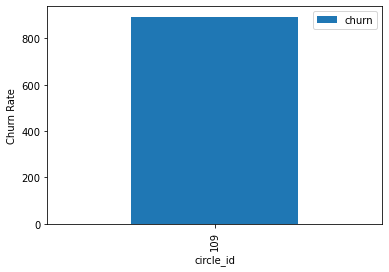

In [459]:
# Let's analyze based on circle
telecom_data_upd.pivot_table(values='churn', index='circle_id', aggfunc = 'sum').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

<AxesSubplot:xlabel='og_action'>

Text(0, 0.5, 'Churn Rate')

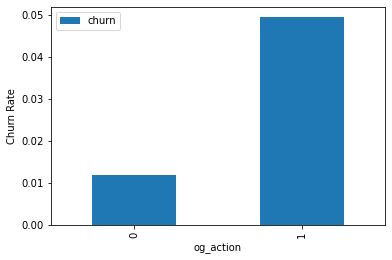

In [460]:
# Let's analyze outgoing calls 
telecom_data_upd.pivot_table(values='churn', index='og_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

Very clearly, churn rate was more for customers who showed decerease in outgoing call trend

<AxesSubplot:xlabel='ic_action'>

Text(0, 0.5, 'Churn Rate')

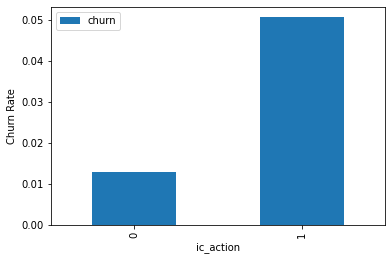

In [461]:
# Let's analyze incoming calls 
telecom_data_upd.pivot_table(values='churn', index='ic_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

Churn rate was more for customers who showed decerease in incoming call trend

<AxesSubplot:xlabel='rech_num_action'>

Text(0, 0.5, 'Churn Rate')

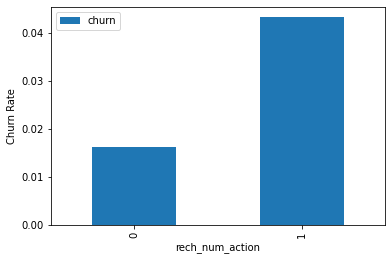

In [462]:
# Let's analyze number of recharges 
telecom_data_upd.pivot_table(values='churn', index='rech_num_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

Churn rate was more for customers who showed decerease in recharge count

<AxesSubplot:xlabel='rech_amt_action'>

Text(0, 0.5, 'Churn Rate')

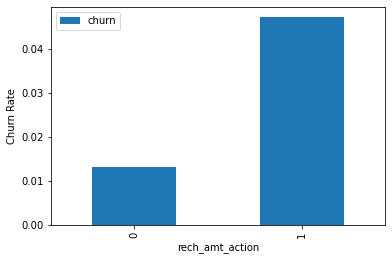

In [463]:
# Let's analyze recharge amount 
telecom_data_upd.pivot_table(values='churn', index='rech_amt_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

Churn rate was more for customers who showed decerease in recharge amount

<AxesSubplot:xlabel='arpu_action'>

Text(0, 0.5, 'Churn Rate')

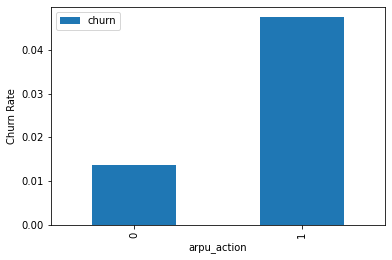

In [464]:
# Let's analyze average revenue per user 
telecom_data_upd.pivot_table(values='churn', index='arpu_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

Churn rate was more for customers who showed decerease in ARPU

<AxesSubplot:xlabel='vbc_action'>

Text(0, 0.5, 'Churn Rate')

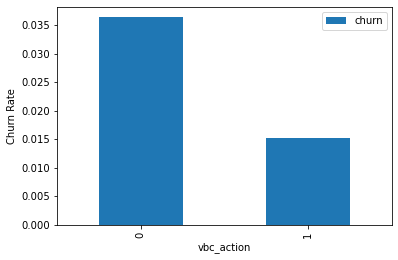

In [465]:
# Let's analyze vbc 
telecom_data_upd.pivot_table(values='churn', index='vbc_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

Here, the volume based cost is more. This means customer who show churn trend have lower volume based cost in action month.

### Step 2.2 - Bivariate Analysis

<AxesSubplot:xlabel='rech_amt_action'>

Text(0, 0.5, 'Churn Rate')

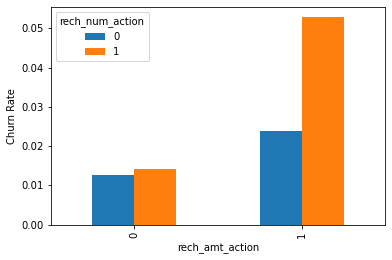

In [466]:
# We'll now do bivariate analysis to see the trend between churn and non churn customers.
telecom_data_upd.pivot_table(values='churn', index='rech_amt_action', columns = 'rech_num_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

As we can see, churn rate seems to be much higher for customers whose reacharge amount and number of recharge in a month decreased in action month

<AxesSubplot:xlabel='rech_amt_action'>

Text(0, 0.5, 'Churn Rate')

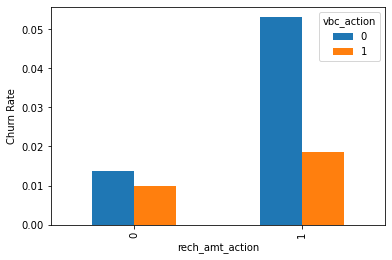

In [467]:
telecom_data_upd.pivot_table(values='churn', index='rech_amt_action', columns = 'vbc_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

As expected, customers with reducing trend in action month and volume based cost increasing trend have higher churn rate.

<AxesSubplot:xlabel='rech_amt_action'>

Text(0, 0.5, 'Churn Rate')

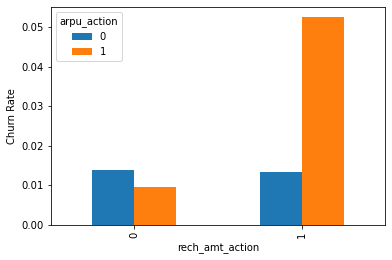

In [468]:
telecom_data_upd.pivot_table(values='churn', index='rech_amt_action', columns = 'arpu_action', aggfunc = 'mean').plot.bar()
plt.ylabel('Churn Rate')
plt.show()

As we can see, churn rate seems to be much higher for customers whose reacharge amount and ARPU in a month decreased in action month

## Step 3 - Data Modelling

In [469]:
# Let's check the data imbalance for churn vs non churn first
round((telecom_data_upd['churn'].mean() * 100), 2)

3.29

There is  very little percentage of churn rate.

### Step 3.1 - Train Test Split

In [470]:
# Putting feature variables into X
X = telecom_data_upd.drop(['mobile_number','churn'], axis = 1)

In [471]:
y = telecom_data_upd['churn']

In [472]:
# Split the dataset in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [473]:
X_train.shape

(18995, 141)

In [474]:
X_test.shape

(8141, 141)

In [475]:
y_train.shape

(18995,)

In [476]:
y_test.shape

(8141,)

In [477]:
smot = SMOTE(random_state=27)

In [478]:
X_train, y_train = smot.fit_sample(X_train, y_train)

### Step 3.2 Feature Scaling

In [479]:
scaler = StandardScaler()

In [480]:
# Create a list of columns to scale
cols_to_scale = X_train.columns.to_list()

In [481]:
# Remove derived variables
cols_to_scale.remove('og_action')
cols_to_scale.remove('ic_action')
cols_to_scale.remove('arpu_action')
cols_to_scale.remove('rech_amt_action')
cols_to_scale.remove('rech_num_action')
cols_to_scale.remove('vbc_action')


In [482]:
cols_to_scale

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7'

In [483]:
# fitting data to scale and transform
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

In [484]:
X_train.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,rech_mnth_6_7_avg,og_action,ic_action,rech_num_action,rech_amt_action,arpu_action,vbc_action
0,0.0,0.0,0.0,0.0,-0.635003,1.870681,0.656163,-0.764552,4.131269,3.555399,-0.948095,-0.668621,-0.654913,-0.260894,-0.267655,-0.311231,-0.316763,-0.384278,-0.434283,-0.373611,-0.331549,-0.270708,-0.677799,-0.408325,-0.458492,-0.282940,-0.266590,-0.243346,-0.274372,-0.225865,0.142091,-0.681704,-0.484574,-0.468842,-0.619328,4.575207,4.177083,-0.632480,-0.510501,-0.424150,-0.138267,-0.128193,-0.115798,0.0,0.0,0.0,-0.895774,2.946967,2.540662,-0.090523,-0.090398,-0.061946,-0.354062,1.589231,0.110050,-0.320341,-0.014784,-0.018539,-1.185615,2.653745,2.001465,-0.441510,-0.383708,-0.318732,-0.678197,-0.562392,-0.475208,-0.293579,-0.232368,-0.262029,-0.737905,-0.618308,-0.519274,-0.248174,-0.214239,-0.178556,-0.354409,-0.319827,-0.255598,-0.121857,-0.125406,-0.101432,0.0,0.0,0.0,-0.410250,-0.361560,-0.295205,-0.829183,-0.699169,-0.572401,-0.36434,-0.118222,-0.193465,-0.154744,-0.153463,-0.126015,-0.073162,-0.007109,-0.067934,-1.291284,-0.213052,-0.333239,-0.639054,2.249430,0.901642,2.487189,0.377135,0.567403,3.650794,1.075106,1.234417,-0.252044,-0.241922,-0.207754,6.186187,-0.271149,-0.251020,-0.252078,-0.248945,-0.234178,-0.261602,-0.272387,-0.264013,2.256839,-0.225241,-0.217731,-0.134716,-0.135848,-0.120056,-1.022895,-0.256832,-0.265354,-0.261378,1.024794,0,0,0,1,1,0
1,0.0,0.0,0.0,0.0,-0.811066,-0.749489,0.105623,-0.031115,0.110499,0.744988,-0.719658,-0.734429,-0.354680,-0.260894,-0.267655,-0.311231,-0.316763,-0.384278,-0.434283,-0.176221,-0.130182,-0.003162,-0.294957,-0.393581,-0.348705,-0.282940,-0.266590,-0.112410,-0.274372,-0.234007,-0.234980,-0.313774,-0.345209,-0.228880,0.072714,0.215272,0.895545,-0.554243,-0.525389,-0.123087,-0.138267,-0.128193,-0.115798,0.0,0.0,0.0,-0.331218,-0.209748,0.522024,-0.090523,-0.090398,-0.061946,-0.354062,-0.156724,-0.276560,-0.320341,-0.014784,-0.018539,-0.472566,-0.365109,0.337890,-0.365332,-0.257480,-0.208832,-0.471546,-0.404911,-0.445518,-0.293579,-0.263395,-0.262029,-0.553909,-0.449314,-0.446845,-0.04999

In [485]:
# Scale test dataset
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [486]:
X_test.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,rech_mnth_6_7_avg,og_action,ic_action,rech_num_action,rech_amt_action,arpu_action,vbc_action
80793,0.0,0.0,0.0,0.0,-0.124002,-0.584050,-1.186052,0.960282,0.564772,-0.559068,-0.589322,-0.623736,-0.715746,-0.260894,-0.267655,-0.311231,-0.316763,-0.384278,-0.434283,0.272588,0.072488,-0.295133,0.090041,-0.229037,-0.546854,-0.282940,-0.266590,-0.243346,-0.274372,-0.019595,-0.23498,0.212460,-0.111262,-0.539779,0.937505,0.611782,-0.420016,-0.580307,-0.474369,-0.428452,-0.138267,-0.128193,-0.115798,0.0,0.0,0.0,0.288696,0.111658,-0.568411,-0.090523,-0.090398,-0.061946,-0.354062,-0.241627,-0.276560,-0.320341,-0.014784,-0.018539,0.364910,0.048339,-0.767254,0.358019,0.448091,-0.163573,-0.024432,-0.007492,-0.250873,-0.293579,-0.279191,-0.262029,0.115710,0.180770,-0.287732,-0.082327,-0.067072,-0.141999,-0.212166,-0.293748,-0.223475,-0.121857,-0.125406,-0.101432,0.0,0.0,0.0,-0.213601,-0.261667,-0.252629,0.015661,0.213687,-0.253584,-0.364340,-0.118222,-0.193465,0.046628,0.942721,0.483574,-0.073162,0.325557,-0.042563,0.160323,-0.213052,-0.828195,0.154867,-0.861073,-1.115105,-0.290151,-0.289267,-0.985904,0.193093,-0.712444,-0.640276,-0.252044,-0.241922,-0.207754,-0.262356,-0.271149,-0.251020,-0.252078,-0.248945,-0.234178,1.168701,0.372688,-0.264013,-0.22586,-0.225241,-0.217731,-0.134716,-0.135848,-0.120056,-0.373428,-0.256832,-0.265354,-0.261378,-0.447746,1,1,1,1,1,0
11930,0.0,0.0,0.0,0.0,-0.775186,-0.367285,-0.393951,-0.690955,-0.719518,-0.557543,0.509584,1.265143,0.846374,-0.260894,-0.267655,-0.311231,-0.316763,-0.384278,-0.434283,-0.373611,-0.341917,-0.295133,-0.677799,-0.660360,-0.546854,-0.282940,-0.266590,-0.180445,-0.274372,-0.234007,-0.23498,-0.681704,-0.649023,-0.536410,-0.542191,-0.576769,-0.418308,0.904389,1.706169,1.345408,-0.138267,-0.128193,-0.115798,0.0,0.0,0.0,0.222869,0.760768,0.603263,-0.090523,-0.090398,-0.061946,-0.354062,-0.330884,0.237370,0.085769,-0.014784,-0.018539,-0.096753,0.423551,0.275396,-0.442019,-0.395662,-0.341276,-0.682314,-0.639202,-0.529236,-0.293579,-0.279191,-0.244518,-0.741122,-0.684516,-0.565910,-0.034197,

### Step 3.3 PCA Modelling

In [487]:
pca = PCA(random_state=42)

In [488]:
# Fiting train set on PCA
pca.fit(X_train)

PCA(random_state=42)

In [489]:
# Checking Principal components
pca.components_

array([[ 7.76991922e-21, -7.89299182e-17,  9.71445147e-17, ...,
        -3.19124144e-02, -3.19467173e-02,  1.71795215e-02],
       [ 6.10519314e-19,  5.55111512e-17, -3.33066907e-16, ...,
        -3.38617936e-03, -3.24571553e-03, -1.76099634e-02],
       [ 8.69073536e-19,  0.00000000e+00,  1.11022302e-16, ...,
        -3.35583476e-02, -3.42627464e-02,  3.28978382e-02],
       ...,
       [ 0.00000000e+00, -7.95632898e-02, -4.65470715e-02, ...,
         1.87350135e-16, -1.48318857e-16,  2.09034179e-16],
       [ 9.99994481e-01, -2.70782091e-03,  2.03909304e-04, ...,
        -9.73071450e-18, -5.28548559e-18,  2.16353391e-18],
       [ 0.00000000e+00, -1.07401205e-02, -7.87343320e-01, ...,
        -4.16333634e-17, -6.93889390e-17, -2.28766658e-17]])

In [490]:
# Checking cumuative variance of principal component
cum_variance = np.cumsum(pca.explained_variance_ratio_)

In [491]:
cum_variance

array([0.11292341, 0.19633285, 0.24879464, 0.29356738, 0.33299039,
       0.37062901, 0.40771109, 0.43724285, 0.46302548, 0.48831142,
       0.51102054, 0.5330774 , 0.55414078, 0.57470125, 0.59334221,
       0.61163451, 0.62783613, 0.64331505, 0.65853971, 0.67268352,
       0.68610354, 0.69889705, 0.71072048, 0.72235203, 0.73335771,
       0.74298539, 0.75232299, 0.76156736, 0.77045237, 0.77883896,
       0.7868184 , 0.79448699, 0.80206862, 0.80939268, 0.81642709,
       0.82312469, 0.82962484, 0.83580067, 0.84187007, 0.84767171,
       0.8531853 , 0.85856798, 0.86382405, 0.86893478, 0.87388635,
       0.87867683, 0.88305268, 0.88726017, 0.89133651, 0.89524664,
       0.89897224, 0.90256402, 0.90607838, 0.90953831, 0.91289518,
       0.91622806, 0.91943411, 0.92254318, 0.92560276, 0.9286504 ,
       0.93159106, 0.9343897 , 0.93710217, 0.93976619, 0.94237435,
       0.94493562, 0.94741668, 0.94984788, 0.95224835, 0.9546081 ,
       0.95694607, 0.95912769, 0.96119638, 0.96322741, 0.96523

<Figure size 720x504 with 0 Axes>

Text(0.5, 0, 'No. of Components')

Text(0, 0.5, 'Cumulative variance')

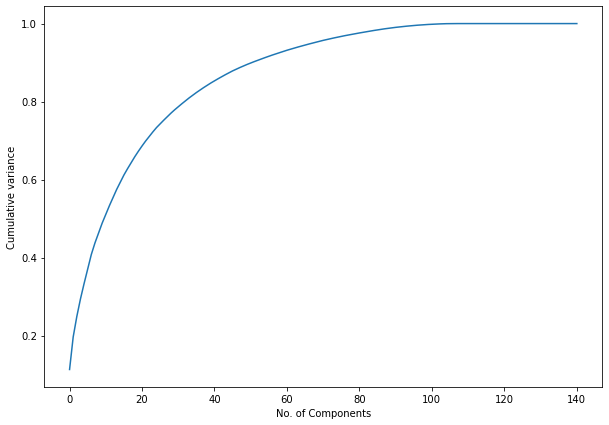

In [492]:
# Plotting Scree plot
plt.figure(figsize=(10,7))
plt.plot(cum_variance)
plt.xlabel('No. of Components')
plt.ylabel('Cumulative variance')

Approx 100 components are able to expain 100% variance of data, while around 60 components are able to explain 90% variance. We'll go ahead with 60 components.

In [493]:
pca_v1 = IncrementalPCA(n_components=60)

In [494]:
X_train_pca = pca_v1.fit_transform(X_train)

In [495]:
X_test_pca = pca_v1.transform(X_test)

For this case study, we'll prefer rather to consider a non churn customer as going to curn and provide the customer with retention benefits rather than assuming the opposite. In this case, Sensitivity / Recall is more important to consider than accuracy. 

In [496]:
# Create KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

#Specify params
params = {'C': [0.01,0.1,1,10,100,1000]}

model_cv = GridSearchCV(estimator=LogisticRegression(),
                       param_grid=params,
                       scoring='recall',
                       cv=folds,
                       verbose=1,
                       return_train_score=True)


In [497]:
# Fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [498]:
# Checking results
cv_results = pd.DataFrame(model_cv.cv_results_)

In [499]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.179421,0.007480,0.007306,0.009103,0.01,{'C': 0.01},0.899073,0.886090,0.887817,0.894921,0.891921,0.891964,0.004711,6,0.891579,0.894401,0.895251,0.890012,0.891593,0.892567,0.001950
1,0.305042,0.021579,0.003116,0.006232,0.1,{'C': 0.1},0.899073,0.888007,0.888644,0.894921,0.891111,0.892351,0.004146,5,0.891171,0.893925,0.896336,0.890626,0.891934,0.892799,0.002093
2,0.393013,0.058491,0.000000,0.000000,1,{'C': 1},0.899891,0.888007,0.888368,0.895189,0.891381,0.892567,0.004480,3,0.891647,0.894129,0.896608,0.891650,0.891934,0.893194,0.001944
3,0.365239,0.018605,0.009375,0.007654,10,{'C': 10},0.899345,0.886637,0.889195,0.895727,0.891651,0.892511,0.004545,4,0.892056,0.894333,0.896608,0.891855,0.892275,0.893425,0.001823
4,0.362428,0.011671,0.003112,0.006223,100,{'C': 100},0.899618,0.887459,0.889195,0.895727,0.891651,0.892730,0.004424,1,0.891851,0.894265,0.896540,0.891650,0.892412,0.893344,0.001845
5,0.386667,0.045585,0.010569,0.006470,1000,{'C': 1000},0.899618,0.887185,0.889195,0.895727,0.891381,0.892621,0.004504,2,0.891987,0.894401,0.896608,0.891718,0.892207,0.893384,0.001873


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'C')

Text(0, 0.5, 'Sensitivity')

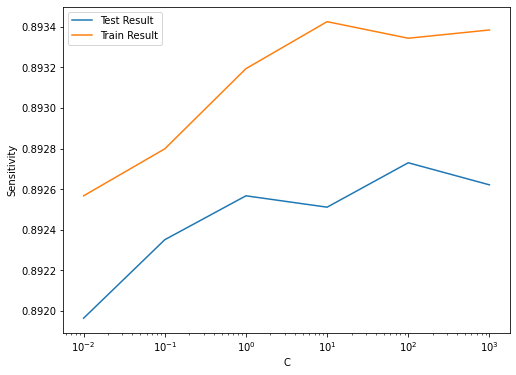

In [500]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Sensitivity')
plt.legend(['Test Result', 'Train Result'], loc='upper left')
plt.xscale('log')

In [501]:
# getting best Score
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

In [502]:
best_C

100

In [503]:
best_score

0.8927300096244639

In [504]:
# Creating logistic regression modelwith best C
log_pca = LogisticRegression(C=best_C)

In [505]:
# Fitting on train set
logreg_pca_model = log_pca.fit(X_train_pca, y_train)

In [506]:
# Now we'll go ahead with prediction on train dataset
y_train_pred = logreg_pca_model.predict(X_train_pca)

In [507]:
# We'll pull the confusion matrix for this model
conf_matrix_logreg = metrics.confusion_matrix(y_train, y_train_pred)

In [508]:
conf_matrix_logreg


array([[15386,  2982],
       [ 1958, 16410]], dtype=int64)

In [509]:
# True Positive
TP = conf_matrix_logreg[1,1]
# True Negative
TN = conf_matrix_logreg[0,0]
# False Positive
FP = conf_matrix_logreg[0,1]
# False Negative
FN = conf_matrix_logreg[1,0]

In [510]:
# Getting Accuracy
metrics.accuracy_score(y_train, y_train_pred)

0.8655270034843205

In [511]:
# Getting Sensitivity
TP / (TP + FN)

0.8934015679442509

In [512]:
# Getting Specificity
TN / (TN + FP)

0.8376524390243902

In [513]:
# We'll now predict on test dataset
y_test_pred = logreg_pca_model.predict(X_test_pca)

In [514]:
# get confusion matrix on test set
conf_matrix_logreg_test = metrics.confusion_matrix(y_test, y_test_pred)

In [515]:
conf_matrix_logreg_test

array([[6632, 1242],
       [  52,  215]], dtype=int64)

In [516]:
# True Positive
TP_test = conf_matrix_logreg_test[1,1]
# True Negative
TN_test = conf_matrix_logreg_test[0,0]
# False Positive
FP_test = conf_matrix_logreg_test[0,1]
# False Negative
FN_test = conf_matrix_logreg_test[1,0]

In [517]:
# getting Accuracy
metrics.accuracy_score(y_test, y_test_pred)

0.8410514678786389

In [518]:
# getting Sensitivity
TP_test / (TP_test + FN_test)

0.8052434456928839

In [519]:
# getting Specificity
TN_test / (TN_test + FP_test)

0.8422656845313691

With the above model
#### Metrics on Train Set
- Accuracy - 0.86
- Sensitivity - 0.89
- Specificity - 0.84

#### Metrics on Test Set
- Accuracy - 0.84
- Sensitivity - 0.81
- Specificity - 0.84

### Step 3.4 - Hyperparameter Tuning 

In [520]:
hyper_param = [{'gamma': [1e-2, 1e-3, 1e-4],
               'C': [1,10,100,1000]}]

In [521]:
model = SVC(kernel='rbf')

In [522]:
# Setup GridsearchCV
model_cv = GridSearchCV(estimator=model,
                       param_grid=hyper_param,
                       scoring='accuracy',
                       cv=3,
                       verbose=1,
                       return_train_score=True)

In [523]:
# Fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [524]:
cv_res = pd.DataFrame(model_cv.cv_results_)

In [525]:
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,18.583594,0.308112,9.863771,0.289834,1,0.01,"{'C': 1, 'gamma': 0.01}",0.942185,0.946427,0.949612,0.946075,0.003042,5,0.952920,0.951697,0.949900,0.951505,0.001240
1,26.854196,0.763338,17.890913,0.287393,1,0.001,"{'C': 1, 'gamma': 0.001}",0.883309,0.884116,0.887056,0.884827,0.001610,10,0.885749,0.887387,0.884896,0.886011,0.001034
2,33.833422,1.366638,23.618194,0.894156,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.856280,0.856921,0.860596,0.857932,0.001902,12,0.857779,0.859050,0.858315,0.858381,0.000521
3,18.020470,0.541388,7.760058,0.394481,10,0.01,"{'C': 10, 'gamma': 0.01}",0.964233,0.967007,0.967824,0.966355,0.001537,3,0.977174,0.975420,0.975746,0.976113,0.000762
4,24.131214,0.354774,14.789934,0.035658,10,0.001,"{'C': 10, 'gamma': 0.001}",0.910746,0.915884,0.915721,0.914117,0.002384,7,0.918987,0.918215,0.916337,0.917846,0.001113
5,28.417830,0.393853,18.247925,0.112007,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.868447,0.868844,0.872846,0.870046,0.001987,11,0.871539,0.872729,0.871218,0.871829,0.000650
6,22.124974,0.869452,5.115093,0.123497,100,0.01,"{'C': 100, 'gamma': 0.01}",0.974441,0.977215,0.977460,0.976372,0.001369,2,0.992160,0.991385,0.991017,0.991521,0.000476
7,27.208749,0.550824,10.919420,0.378024,100,0.001,"{'C': 100, 'gamma': 0.001}",0.936551,0.940955,0.942180,0.939896,0.002417,6,0.949367,0.947205,0.945286,0.947286,0.001667
8,27.434020,0.314440,16.639680,0.191387,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.884289,0.885341,0.888281,0.885970,0.001689,9,0.889138,0.887918,0.887183,0.888080,0.000806
9,32.699710,1.170572,3.886276,0.150638,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.973379,0.978440,0.977624,0.976481,0.002219,1,0.998938,0.998653,0.998408,0.998666,0.000217


In [526]:
# We'll now plot accuracy with C and gamma values. First let's convert C into int.
cv_res['param_C'] = cv_res['param_C'].astype('int')

Text(0.5, 0, 'C')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Gamma at value 0.01')

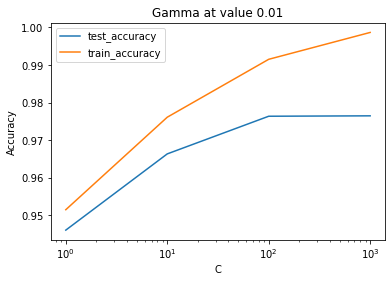

In [527]:
# Gamma value = 0.01
gamma_01 = cv_res[cv_res['param_gamma']==0.01]
plt.plot(gamma_01['param_C'], gamma_01['mean_test_score'])
plt.plot(gamma_01['param_C'], gamma_01['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title ('Gamma at value 0.01')
plt.legend(['test_accuracy','train_accuracy'], loc='upper left')
plt.xscale('log')
plt.show()

Text(0.5, 0, 'C')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Gamma at value 0.001')

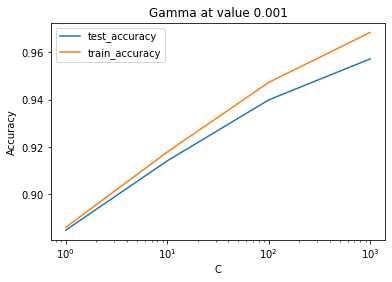

In [528]:
# Gamma value = 0.001
gamma_01 = cv_res[cv_res['param_gamma']==0.001]
plt.plot(gamma_01['param_C'], gamma_01['mean_test_score'])
plt.plot(gamma_01['param_C'], gamma_01['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title ('Gamma at value 0.001')
plt.legend(['test_accuracy','train_accuracy'], loc='upper left')
plt.xscale('log')
plt.show()

Text(0.5, 0, 'C')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Gamma at value 0.0001')

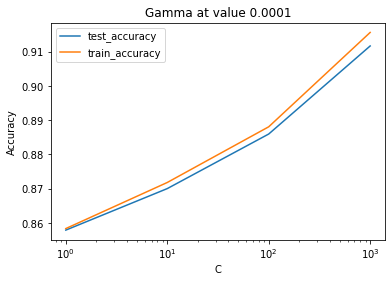

In [529]:
# Gamma value = 0.0001
gamma_01 = cv_res[cv_res['param_gamma']==0.0001]
plt.plot(gamma_01['param_C'], gamma_01['mean_test_score'])
plt.plot(gamma_01['param_C'], gamma_01['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title ('Gamma at value 0.0001')
plt.legend(['test_accuracy','train_accuracy'], loc='upper left')
plt.xscale('log')
plt.show()

In [530]:
best_scr = model_cv.best_score_
best_hyp = model_cv.best_params_

In [531]:
best_scr

0.9764809206734028

In [532]:
best_hyp

{'C': 1000, 'gamma': 0.01}

Although the best score and gamma values are 1000 and 0.01 as per sklearn metrics, we'll look to make the model much simpler by choosing a lower value of gamma (0.0001) as we can see the accuracy nearly similar for train and test (although accuracy drops to 0.91 when compared to gamma at 0.01 which was nearly .98, which also suggests that the model may be overfitting).
The model is able to achieve approx 0.9 accuracy with gamma as 0.0001 and C as 100. We'll go ahead with using this further.

In [533]:
# Build the model again with optimal hyperparameters
pca_v2 = SVC(C=100, gamma=0.0001, kernel='rbf')

In [534]:
pca_v2.fit(X_train_pca, y_train)

SVC(C=100, gamma=0.0001)

In [535]:
# Predict on train set
y_train_pred = pca_v2.predict(X_train_pca)

In [536]:
conf_mtrx = metrics.confusion_matrix(y_train, y_train_pred)

In [537]:
conf_mtrx

array([[15830,  2538],
       [ 1441, 16927]], dtype=int64)

In [538]:
# True Positive
TP = conf_mtrx[1,1]
# True Negative
TN = conf_mtrx[0,0]
# False Positive
FP = conf_mtrx[0,1]
# False Negative
FN = conf_mtrx[1,0]

In [539]:
# Accuracy
metrics.accuracy_score(y_train, y_train_pred)

0.8916866289198606

In [540]:
# Sensitivity
TP / (TP + FN)

0.9215483449477352

In [541]:
# Specificity
TN / (TN + FP)

0.861824912891986

In [542]:
# Predict on test set
y_test_pred = pca_v2.predict(X_test_pca)

In [543]:
conf_mtrx_test = metrics.confusion_matrix(y_test, y_test_pred)

In [544]:
conf_mtrx_test

array([[6837, 1037],
       [  60,  207]], dtype=int64)

In [545]:
# True Positive
TP_test = conf_mtrx_test[1,1]
# True Negative
TN_test = conf_mtrx_test[0,0]
# False Positive
FP_test = conf_mtrx_test[0,1]
# False Negative
FN_test = conf_mtrx_test[1,0]

In [546]:
# Accuracy
metrics.accuracy_score(y_test, y_test_pred)

0.8652499692912419

In [547]:
# Sensitivity
TP_test / (TP_test + FN_test)

0.7752808988764045

In [548]:
# Specificity
TN_test / (TN_test + FP_test)

0.8683007366014732

With the above model
#### Metrics on Train Set
- Accuracy - 0.89
- Sensitivity - 0.92
- Specificity - 0.86

#### Metrics on Test Set
- Accuracy - 0.86
- Sensitivity - 0.77
- Specificity - 0.87

### Step 3.5 - Decision Tree with PCA model

In [549]:
# Craete parameter grid
param_grid = {'max_depth': range(5,15,5),
             'min_samples_leaf': range(50,150,50),
             'min_samples_split': range(50,150,50)}

In [550]:
dec_tree = DecisionTreeClassifier()

In [551]:
grid_srch_cv = GridSearchCV(estimator=dec_tree,
                           param_grid=param_grid,
                           scoring = 'recall',
                           cv=5,
                           verbose=1)

In [552]:
grid_srch_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [553]:
cv_res = pd.DataFrame(grid_srch_cv.cv_results_)

In [554]:
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.405082,0.102108,0.003125,0.006249,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.819271,0.854342,0.830384,0.800762,0.824986,0.825949,0.017354,5
1,1.154980,0.027107,0.000000,0.000000,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.818726,0.854342,0.830384,0.800762,0.824986,0.825840,0.017397,6
2,1.165881,0.042285,0.000000,0.000000,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.810833,0.855704,0.832562,0.795318,0.826892,0.824262,0.020408,7
3,1.314447,0.130484,0.003125,0.006250,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.810833,0.855704,0.832562,0.795318,0.826892,0.824262,0.020408,7
4,2.087550,0.176606,0.003125,0.006250,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.900381,0.895726,0.893275,0.904736,0.897387,0.898301,0.003961,1
5,2.003199,0.065422,0.006260,0.007667,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.900381,0.895726,0.893003,0.905280,0.896026,0.898083,0.004305,2
6,1.969991,0.161015,0.009376,0.007655,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.876157,0.877212,0.885924,0.873707,0.882689,0.879138,0.004489,3
7,1.895422,0.021656,0.003126,0.006252,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.876157,0.877212,0.885924,0.873707,0.882689,0.879138,0.004489,3


In [555]:
# Best score
grid_srch_cv.best_score_

0.898300979902927

In [556]:
# Best Params
grid_srch_cv.best_params_

{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50}

In [557]:
# best Estimator
grid_srch_cv.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)

In [558]:
# Building model with optimal hyperparameters
pca_v3 = DecisionTreeClassifier(criterion='gini',
                               random_state=100,
                               max_depth=10,
                               min_samples_leaf=50,
                               min_samples_split=100)

In [559]:
pca_v3.fit(X_train_pca, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=100,
                       random_state=100)

In [560]:
# Prediction on train set
y_train_pred = pca_v3.predict(X_train_pca)

In [561]:
# get confusion matrix
conf_mtrx = metrics.confusion_matrix(y_train, y_train_pred)

In [562]:
conf_mtrx

array([[16245,  2123],
       [ 1541, 16827]], dtype=int64)

In [563]:
# True Positive
TP = conf_mtrx[1,1]
# True Negative
TN = conf_mtrx[0,0]
# False Positive
FP = conf_mtrx[0,1]
# False Negative
FN = conf_mtrx[1,0]

In [564]:
# Accuracy
metrics.accuracy_score(y_train, y_train_pred)

0.9002613240418118

In [565]:
# Sensitivity
TP / (TP + FN)

0.916104094076655

In [566]:
# Specificity
TN / (TN + FP)

0.8844185540069687

In [567]:
# Predict on test set
y_test_pred = pca_v3.predict(X_test_pca)

In [568]:
conf_mtrx_test = metrics.confusion_matrix(y_test, y_test_pred)

In [569]:
conf_mtrx_test

array([[6879,  995],
       [ 101,  166]], dtype=int64)

In [570]:
# True Positive
TP_test = conf_mtrx_test[1,1]
# True Negative
TN_test = conf_mtrx_test[0,0]
# False Positive
FP_test = conf_mtrx_test[0,1]
# False Negative
FN_test = conf_mtrx_test[1,0]

In [571]:
# Accuracy
metrics.accuracy_score(y_test, y_test_pred)

0.8653728043237932

In [572]:
# Sensitivity
TP_test / (TP_test + FN_test)

0.6217228464419475

In [573]:
# Specificity
TN_test / (TN_test + FP_test)

0.8736347472694945

With the above model
#### Metrics on Train Set
- Accuracy - 0.90
- Sensitivity - 0.92
- Specificity - 0.88

#### Metrics on Test Set
- Accuracy - 0.86
- Sensitivity - 0.62
- Specificity - 0.87

Although accuracy and specificity are good, sensitivity has decerased significantly and cannot be ignored due to the nature of teh case. 

### Step 3.6 - Random Forest with PCA

In [574]:
# Create param grid
param_grid = {'max_depth': range(5,10,15),
             'min_samples_leaf': range(50,150,50),
             'min_samples_split': range(50,150,50),
             'n_estimators': [100,200,300],
             'max_features': [10,20]}

In [575]:
rf_model = RandomForestClassifier()

In [576]:
grid_srch_cv = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=1,
                           return_train_score=True)

In [577]:
#Fit the model
grid_srch_cv.fit(X_train_pca, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 10, 15),
                         'max_features': [10, 20],
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, verbose=1)

In [578]:
# Best score
grid_srch_cv.best_score_

0.8382786580467684

In [579]:
# Best params
grid_srch_cv.best_params_

{'max_depth': 5,
 'max_features': 20,
 'min_samples_leaf': 50,
 'min_samples_split': 50,
 'n_estimators': 200}

In [580]:
# Let's model with optimal hyperparameters
rfc_model = RandomForestClassifier(bootstrap=True,
                                  max_depth=5,
                                  min_samples_leaf=50,
                                  min_samples_split=100,
                                  max_features=10,
                                  n_estimators=200)

In [581]:
# Fit the model
rfc_model.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=5, max_features=10, min_samples_leaf=50,
                       min_samples_split=100, n_estimators=200)

In [582]:
# Let's predict on Train set
y_train_pred = rfc_model.predict(X_train_pca)

In [583]:
# get confusion matrix
conf_mtrx = metrics.confusion_matrix(y_train, y_train_pred)

In [584]:
conf_mtrx


array([[14709,  3659],
       [ 2059, 16309]], dtype=int64)

In [585]:
# True Positive
TP = conf_mtrx[1,1]
# True Negative
TN = conf_mtrx[0,0]
# False Positive
FP = conf_mtrx[0,1]
# False Negative
FN = conf_mtrx[1,0]

In [586]:
# Accuracy
metrics.accuracy_score(y_train, y_train_pred)

0.8443488675958188

In [587]:
# Sensitivity
TP / (TP + FN)

0.8879028745644599

In [588]:
# Specificity
TN / (TN + FP)

0.8007948606271778

In [589]:
# Predict on test set
y_test_pred = rfc_model.predict(X_test_pca)

In [590]:
conf_mtrx_test = metrics.confusion_matrix(y_test, y_test_pred)

In [591]:
conf_mtrx_test

array([[6301, 1573],
       [  73,  194]], dtype=int64)

In [592]:
# True Positive
TP_test = conf_mtrx_test[1,1]
# True Negative
TN_test = conf_mtrx_test[0,0]
# False Positive
FP_test = conf_mtrx_test[0,1]
# False Negative
FN_test = conf_mtrx_test[1,0]

In [593]:
# Accuracy
metrics.accuracy_score(y_test, y_test_pred)

0.7978135364205872

In [594]:
# Sensitivity
TP_test / (TP_test + FN_test)

0.7265917602996255

In [595]:
# Specificity
TN_test / (TN_test + FP_test)

0.8002286004572009

With the above model
#### Metrics on Train Set
- Accuracy - 0.84
- Sensitivity - 0.88
- Specificity - 0.80

#### Metrics on Test Set
- Accuracy - 0.80
- Sensitivity - 0.73
- Specificity - 0.80

Using PCA, the best sensitivity we could get for test set was 81% (where train set was 89%).

## Step 4 - Model without PCA

In [596]:
log_reg = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())

In [597]:
#Fit the model
log_reg = log_reg.fit().summary()

In [598]:
log_reg


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                36736
Model:                            GLM   Df Residuals:                    36604
Model Family:                Binomial   Df Model:                          131
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 04 Sep 2022   Deviance:                       75893.
Time:                        18:34:59   Pearson chi2:                 3.71e+18
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.231e+15   1.14e+06   1.08e+09      0.000    1.23e+15    1.23e+15
circle_id          -5.115e+06      0.839   -6.1e+06      0.000   -5.12e+06   -5.12e+06
loc_og_t2o_mou     -3.904e+07      1.582  -2.47e+07      0.000    -3.9e+07    -3.9e+07
std_og_t2o_mou     -8.185e+06      1.557  -5.26e+06      0.000   -8.18e+06   -8.18e+06
loc_ic_t2o_mou     -3.258e+07      1.394  -2.34e+07      0.000   -3.26e+07   -3.26e+07
arpu_6              7.344e+12   1.33e+06   5.54e+06      0.000    7.34e+12    7.34e+12
arpu_7             -7.006e+13   1.47e+06  -4.76e+07      0.000   -7.01e+13   -7.01e+13
arpu_8             -1.796e+13   1.78e+06  -1.01e+07      0.000    -1.8e+13    -1.8e+13
onnet_mou_6         1.899e+15   6.02e+07   3.16e+07      0.000     1.9e+15     1.9e+15
onnet_mou_7         1.496e+15   3.48e+07    4.3e+07      0.000     1.5e+15     1.5e+15
onnet_mou_8         4.954e+14   2.49e+07   1.99e+07      0.000    4.95e+14    4.95e+14
offnet_mou_6        1.901e+15   5.65e+07   3.36e+07      0.000     1.9e+15     1.9e+15
offnet_mou_7        1.726e+15   3.24e+07   5.33e+07      0.000    1.73e+15    1.73e+15
offnet_mou_8        3.395e+14   2.44e+07   1.39e+07      0.000     3.4e+14     3.4e+14
roam_ic_mou_6       1.574e+13   6.24e+05   2.52e+07      0.000    1.57e+13    1.57e+13
roam_ic_mou_7      -1.443e+13   7.02e+05  -2.05e+07      0.000   -1.44e+13   -1.44e+13
roam_ic_mou_8       4.427e+13   5.96e+05   7.43e+07      0.000    4.43e+13    4.43e+13
roam_og_mou_6      -4.989e+14   1.59e+07  -3.13e+07      0.000   -4.99e+14   -4.99e+14
roam_og_mou_7      -3.999e+14   8.62e+06  -4.64e+07      0.000      -4e+14      -4e+14
roam_og_mou_8      -1.039e+14   7.07e+06  -1.47e+07      0.000   -1.04e+14   -1.04e+14
loc_og_t2t_mou_6   -7.601e+17   1.33e+10  -5.73e+07      0.000    -7.6e+17    -7.6e+17
loc_og_t2t_mou_7    6.031e+17   1.33e+10   4.53e+07      0.000    6.03e+17    6.03e+17
loc_og_t2t_mou_8    1.948e+18   1.32e+10   1.48e+08      0.000    1.95e+18    1.95e+18
loc_og_t2m_mou_6   -7.786e+17   1.36e+10  -5.73e+07      0.000   -7.79e+17   -7.79e+17
loc_og_t2m_mou_7    5.839e+17   1.29e+10   4.53e+07      0.000    5.84e+17    5.84e+17
loc_og_t2m_mou_8    2.021e+18   1.36e+10   1.48e+08      0.000    2.02e+18    2.02e+18
loc_og_t2f_mou_6   -6.559e+16   1.14e+09  -5.74e+07      0.000   -6.56e+16   -6.56e+16
loc_og_t2f_mou_7     5.17e+16   1.14e+09   4.52e+07      0.000    5.17e+16    5.17e+16
loc_og_t2f_mou_8    1.709e+17   1.15e+09   1.48e+08      0.000    1.71e+17    1.71e+17
loc_og_t2c_mou_6    1.183e+13   4.45e+05   2.66e+07      0.000    1.18e+13    1.18e+13
loc_og_t2c_mou_7   -7.849e+12   5.03e+05  -1.56e+07      0.000   -7.85e+12   -7.85e+12
loc_og_t2c_mou_8   -1.244e+13   4.62e+05  -2.69e+07      0.000   -1.24e+13   -1.24e+13
loc_og_mou_6        7.868e+17   2.58e+

In [599]:
# There are too many features and all can't be part of model. We'll use RFE to choose top 15 fields.
logreg = LogisticRegression()

In [600]:
rfe = RFE(logreg, 15)

In [601]:
rfe = rfe.fit(X_train, y_train)

In [602]:
# Let's see which columns are selected via RFE
rfe_col = X_train.columns[rfe.support_]

In [603]:
rfe_col

Index(['onnet_mou_8', 'offnet_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_8', 'og_others_8', 'total_og_mou_7',
       'total_og_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'ic_others_8',
       'monthly_2g_8', 'monthly_3g_8', 'vbc_action'],
      dtype='object')

In [604]:
# Let's create first model with RFE selected columns

X_train_sm1 = sm.add_constant(X_train[rfe_col])
logreg1 = sm.GLM(y_train, X_train_sm1, family=sm.families.Binomial())

# Fit the model
logreg1 = logreg1.fit()
logreg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                36736
Model:                            GLM   Df Residuals:                    36720
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 04 Sep 2022   Deviance:                       25684.
Time:                        18:36:31   Pearson chi2:                 7.46e+05
No. Iterations:                    35                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -34.4382   5733.146     -0.006      0.995   -1.13e+04    1.12e+04
onnet_mou_8          3.0855      0.109     28.328      0.000       2.872       3.299
offnet_mou_7         2.0124      0.131     15.304      0.000       1.755       2.270
loc_og_t2t_mou_7     0.9760      0.084     11.662      0.000       0.812       1.140
loc_og_t2t_mou_8    -0.7821      0.103     -7.618      0.000      -0.983      -0.581
std_og_t2t_mou_7     1.9176      0.137     13.965      0.000       1.648       2.187
std_og_t2m_mou_8     2.6359      0.094     28.085      0.000       2.452       2.820
og_others_8      -1803.3699   3.09e+05     -0.006      0.995   -6.08e+05    6.04e+05
total_og_mou_7      -2.1066      0.188    -11.222      0.000      -2.474      -1.739
total_og_mou_8      -5.4616      0.159    -34.331      0.000      -5.773      -5.150
loc_ic_t2f_mou_8    -0.8445      0.077    -10.906      0.000      -0.996      -0.693
loc_ic_mou_8        -1.4493      0.068    -21.402      0.000      -1.582      -1.317
ic_others_8         -2.4758      0.205    -12.063      0.000      -2.878      -2.074
monthly_2g_8        -0.7373      0.041    -18.033      0.000      -0.817      -0.657
monthly_3g_8        -1.0848      0.054    -20.050      0.000      -1.191      -0.979
vbc_action          -1.3204      0.066    -19.959      0.000      -1.450      -1.191
====================================================================================
"""

In [605]:
# Let's check the VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,total_og_mou_7,64.95
4,std_og_t2t_mou_7,36.33
1,offnet_mou_7,30.85
8,total_og_mou_8,14.20
2,loc_og_t2t_mou_7,10.17
0,onnet_mou_8,9.04
5,std_og_t2m_mou_8,5.63
3,loc_og_t2t_mou_8,4.81
10,loc_ic_mou_8,1.73
9,loc_ic_t2f_mou_8,1.21


In [606]:
# We'll remove og_others_8, which has high p-value
logreg_col = rfe_col.to_list()
logreg_col.remove('og_others_8')

In [607]:
logreg_col

['onnet_mou_8',
 'offnet_mou_7',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'std_og_t2t_mou_7',
 'std_og_t2m_mou_8',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'ic_others_8',
 'monthly_2g_8',
 'monthly_3g_8',
 'vbc_action']

In [608]:
# Let's build a second model
X_train_sm2 = sm.add_constant(X_train[logreg_col])
logreg2 = sm.GLM(y_train, X_train_sm2, family=sm.families.Binomial())

# Fit the model
logreg2 = logreg2.fit()
logreg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                36736
Model:                            GLM   Df Residuals:                    36721
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12870.
Date:                Sun, 04 Sep 2022   Deviance:                       25740.
Time:                        18:36:32   Pearson chi2:                 7.74e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.0118      0.030    -33.273      0.000      -1.071      -0.952
onnet_mou_8          3.0979      0.109     28.429      0.000       2.884       3.311
offnet_mou_7         2.0206      0.132     15.351      0.000       1.763       2.279
loc_og_t2t_mou_7     0.9834      0.084     11.749      0.000       0.819       1.147
loc_og_t2t_mou_8    -0.7899      0.103     -7.691      0.000      -0.991      -0.589
std_og_t2t_mou_7     1.9260      0.137     14.015      0.000       1.657       2.195
std_og_t2m_mou_8     2.6450      0.094     28.166      0.000       2.461       2.829
total_og_mou_7      -2.1210      0.188    -11.288      0.000      -2.489      -1.753
total_og_mou_8      -5.4773      0.159    -34.412      0.000      -5.789      -5.165
loc_ic_t2f_mou_8    -0.8450      0.077    -10.921      0.000      -0.997      -0.693
loc_ic_mou_8        -1.4447      0.068    -21.346      0.000      -1.577      -1.312
ic_others_8         -2.4829      0.205    -12.085      0.000      -2.886      -2.080
monthly_2g_8        -0.7365      0.041    -18.012      0.000      -0.817      -0.656
monthly_3g_8        -1.0853      0.054    -20.047      0.000      -1.191      -0.979
vbc_action          -1.3230      0.066    -20.018      0.000      -1.453      -1.193
====================================================================================
"""

In [609]:
# Let's check the VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[logreg_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[logreg_col].values, i) for i in range(X_train[logreg_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,total_og_mou_7,64.95
4,std_og_t2t_mou_7,36.33
1,offnet_mou_7,30.85
7,total_og_mou_8,14.20
2,loc_og_t2t_mou_7,10.17
0,onnet_mou_8,9.04
5,std_og_t2m_mou_8,5.63
3,loc_og_t2t_mou_8,4.81
9,loc_ic_mou_8,1.73
8,loc_ic_t2f_mou_8,1.21


In [610]:
# We'll delete total_og_mou_8 as it has highest VIF
logreg_col.remove('total_og_mou_8')

In [611]:
logreg_col

['onnet_mou_8',
 'offnet_mou_7',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'std_og_t2t_mou_7',
 'std_og_t2m_mou_8',
 'total_og_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'ic_others_8',
 'monthly_2g_8',
 'monthly_3g_8',
 'vbc_action']

In [612]:
# Let's build a third model
X_train_sm3 = sm.add_constant(X_train[logreg_col])
logreg3 = sm.GLM(y_train, X_train_sm3, family=sm.families.Binomial())

# Fit the model
logreg3 = logreg3.fit()
logreg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                36736
Model:                            GLM   Df Residuals:                    36722
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13774.
Date:                Sun, 04 Sep 2022   Deviance:                       27547.
Time:                        18:36:33   Pearson chi2:                 5.53e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1093      0.030    -36.465      0.000      -1.169      -1.050
onnet_mou_8         -0.4848      0.027    -18.107      0.000      -0.537      -0.432
offnet_mou_7         3.0443      0.134     22.663      0.000       2.781       3.308
loc_og_t2t_mou_7     1.7743      0.082     21.702      0.000       1.614       1.935
loc_og_t2t_mou_8    -1.4943      0.107    -13.989      0.000      -1.704      -1.285
std_og_t2t_mou_7     3.1863      0.139     22.869      0.000       2.913       3.459
std_og_t2m_mou_8    -0.4048      0.023    -17.974      0.000      -0.449      -0.361
total_og_mou_7      -3.8819      0.190    -20.396      0.000      -4.255      -3.509
loc_ic_t2f_mou_8    -0.8234      0.079    -10.383      0.000      -0.979      -0.668
loc_ic_mou_8        -2.9328      0.064    -45.788      0.000      -3.058      -2.807
ic_others_8         -2.4717      0.201    -12.309      0.000      -2.865      -2.078
monthly_2g_8        -0.7559      0.040    -18.683      0.000      -0.835      -0.677
monthly_3g_8        -1.1438      0.057    -20.205      0.000      -1.255      -1.033
vbc_action          -1.3508      0.065    -20.777      0.000      -1.478      -1.223
====================================================================================
"""

In [613]:
# Let's check the VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[logreg_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[logreg_col].values, i) for i in range(X_train[logreg_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,total_og_mou_7,62.21
4,std_og_t2t_mou_7,34.68
1,offnet_mou_7,30.26
2,loc_og_t2t_mou_7,9.76
3,loc_og_t2t_mou_8,4.76
0,onnet_mou_8,2.51
5,std_og_t2m_mou_8,1.68
8,loc_ic_mou_8,1.39
7,loc_ic_t2f_mou_8,1.21
12,vbc_action,1.09


In [614]:
# We'll delete total_og_mou_7 as it has highest VIF
logreg_col.remove('total_og_mou_7')

In [615]:
logreg_col

['onnet_mou_8',
 'offnet_mou_7',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'std_og_t2t_mou_7',
 'std_og_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'ic_others_8',
 'monthly_2g_8',
 'monthly_3g_8',
 'vbc_action']

In [616]:
# Let's build a fourth model
X_train_sm4 = sm.add_constant(X_train[logreg_col])
logreg4 = sm.GLM(y_train, X_train_sm4, family=sm.families.Binomial())

# Fit the model
logreg4 = logreg4.fit()
logreg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                36736
Model:                            GLM   Df Residuals:                    36723
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14067.
Date:                Sun, 04 Sep 2022   Deviance:                       28133.
Time:                        18:36:34   Pearson chi2:                 3.64e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1615      0.030    -39.038      0.000      -1.220      -1.103
onnet_mou_8         -0.3973      0.026    -15.537      0.000      -0.447      -0.347
offnet_mou_7         0.3839      0.023     16.985      0.000       0.340       0.428
loc_og_t2t_mou_7     0.5526      0.056      9.796      0.000       0.442       0.663
loc_og_t2t_mou_8    -1.4396      0.105    -13.736      0.000      -1.645      -1.234
std_og_t2t_mou_7     0.3679      0.024     15.282      0.000       0.321       0.415
std_og_t2m_mou_8    -0.4795      0.023    -21.019      0.000      -0.524      -0.435
loc_ic_t2f_mou_8    -0.8570      0.080    -10.675      0.000      -1.014      -0.700
loc_ic_mou_8        -3.1451      0.064    -49.106      0.000      -3.271      -3.020
ic_others_8         -2.5379      0.201    -12.625      0.000      -2.932      -2.144
monthly_2g_8        -0.7393      0.038    -19.351      0.000      -0.814      -0.664
monthly_3g_8        -0.9731      0.050    -19.594      0.000      -1.070      -0.876
vbc_action          -1.3162      0.063    -20.950      0.000      -1.439      -1.193
====================================================================================
"""

In [617]:
# Let's check the VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[logreg_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[logreg_col].values, i) for i in range(X_train[logreg_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,loc_og_t2t_mou_8,4.76
2,loc_og_t2t_mou_7,4.00
0,onnet_mou_8,2.49
4,std_og_t2t_mou_7,2.06
1,offnet_mou_7,1.65
5,std_og_t2m_mou_8,1.65
7,loc_ic_mou_8,1.37
6,loc_ic_t2f_mou_8,1.21
11,vbc_action,1.09
9,monthly_2g_8,1.06


P values and VIF values are under control. Hence we can say that X_train_sm4 (logreg4) is our final model for further consideration.

In [618]:
# Let's check moodel performance on train set
y_train_logreg = logreg4.predict(X_train_sm4)

In [619]:
y_train_logreg.head()

0    0.842529
1    0.626831
2    0.020910
3    0.853859
4    0.043404
dtype: float64

In [620]:
y_train_pred_final = pd.DataFrame({'churn': y_train.values, 'churn_prob': y_train_logreg.values})

In [621]:
y_train_pred_final['CustID'] = y_train_pred_final.index
y_train_pred_final

,churn,churn_prob,CustID
0,0,0.842529,0
1,0,0.626831,1
2,0,0.020910,2
3,0,0.853859,3
4,0,0.043404,4
...,...,...,...
36731,1,0.842395,36731
36732,1,0.841350,36732
36733,1,0.943115,36733
36734,1,0.797899,36734


In [622]:
# Find optimal cutoff point
opt_cutoff = [float(i/10) for i in range(10)]

for j in opt_cutoff:
    y_train_pred_final[j] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > j else 0)

In [623]:
y_train_pred_final

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.842529,0,1,1,1,1,1,1,1,1,1,0
1,0,0.626831,1,1,1,1,1,1,1,1,0,0,0
2,0,0.020910,2,1,0,0,0,0,0,0,0,0,0
3,0,0.853859,3,1,1,1,1,1,1,1,1,1,0
4,0,0.043404,4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36731,1,0.842395,36731,1,1,1,1,1,1,1,1,1,0
36732,1,0.841350,36732,1,1,1,1,1,1,1,1,1,0
36733,1,0.943115,36733,1,1,1,1,1,1,1,1,1,1
36734,1,0.797899,36734,1,1,1,1,1,1,1,1,0,0


In [624]:
# We'll now calculate accuracy, senisitivty and specificity for various probablity cutoffs
cutoff_inf = pd.DataFrame(columns=['probability', 'accuracy', 'sensitivity', 'specificity'])

for i in opt_cutoff:
    conf_mtrx1 = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final[i])
    tot1 = sum(sum(conf_mtrx1))
    accuracy = (conf_mtrx1[0,0] + conf_mtrx1[1,1]) / tot1
    specificity = conf_mtrx1[0,0] / (conf_mtrx1[0,0] + conf_mtrx1[0,1])
    sensitivity = conf_mtrx1[1,1] / (conf_mtrx1[1,0] + conf_mtrx1[1,1])
    cutoff_inf.loc[i] = [i, accuracy, sensitivity, specificity]

In [625]:
cutoff_inf

,probability,accuracy,sensitivity,specificity
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.746706,0.982796,0.510616
0.2,0.2,0.777357,0.960094,0.594621
0.3,0.3,0.798917,0.938752,0.659081
0.4,0.4,0.817808,0.918990,0.716627
0.5,0.5,0.831609,0.890516,0.772703
0.6,0.6,0.833406,0.836400,0.830412
0.7,0.7,0.831854,0.773465,0.890244
0.8,0.8,0.796712,0.645307,0.948116
0.9,0.9,0.564106,0.139155,0.989057


<AxesSubplot:xlabel='probability'>

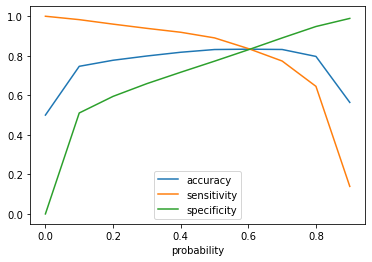

In [626]:
# Let's plot the above dataframe
cutoff_inf.plot('probability',['accuracy','sensitivity','specificity'])
plt.show()

Probability at 0.6 is where the optimal cutoff is idenitified. Although, since our focus is more towards sensitivity, let's take 0.5 which has a bit higher sensitivity, a bit lower specificity and accuracy is stil maintained.

In [627]:
# Let's create another column to provide the predicted value as per probability as 0.5
y_train_pred_final['predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

In [628]:
y_train_pred_final

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,0.842529,0,1,1,1,1,1,1,1,1,1,0,1
1,0,0.626831,1,1,1,1,1,1,1,1,0,0,0,1
2,0,0.020910,2,1,0,0,0,0,0,0,0,0,0,0
3,0,0.853859,3,1,1,1,1,1,1,1,1,1,0,1
4,0,0.043404,4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36731,1,0.842395,36731,1,1,1,1,1,1,1,1,1,0,1
36732,1,0.841350,36732,1,1,1,1,1,1,1,1,1,0,1
36733,1,0.943115,36733,1,1,1,1,1,1,1,1,1,1,1
36734,1,0.797899,36734,1,1,1,1,1,1,1,1,0,0,1


In [629]:
# let's get the confusion matrix
conf_mtrx = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['predicted'])

In [630]:
conf_mtrx

array([[14193,  4175],
       [ 2011, 16357]], dtype=int64)

In [631]:
# True Positive
TP = conf_mtrx[1,1]
# True Negative
TN = conf_mtrx[0,0]
# False Positive
FP = conf_mtrx[0,1]
# False Negative
FN = conf_mtrx[1,0]

In [632]:
# Accuracy
metrics.accuracy_score(y_train, y_train_pred)

0.8443488675958188

In [633]:
# Sensitivity
TP / (TP + FN)

0.8905161149825784

In [634]:
# Specificity
TN / (TN + FP)

0.7727025261324042

In [635]:
# Let's plot an ROC curve
def roc_curve( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

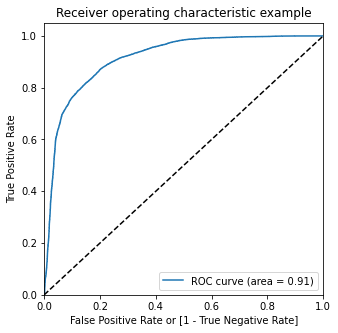

In [636]:
roc_curve(y_train_pred_final['churn'], y_train_pred_final['churn_prob'])

In [637]:
# let's evaluate the model against test set
X_test_cpy = X_test.copy()

In [638]:
X_test = X_test[logreg_col]

In [639]:
# Add constant to test set
X_test_sm = sm.add_constant(X_test)

In [640]:
y_test_pred = logreg4.predict(X_test_sm)

In [641]:
y_test_pred

80793    0.792341
11930    0.229674
39023    0.000003
55864    0.064044
53600    0.022284
           ...   
3152     0.050829
21036    0.003242
38447    0.001583
86488    0.000486
19875    0.033952
Length: 8141, dtype: float64

In [642]:
y_test_pred_df = pd.DataFrame(y_test_pred)

In [643]:
y_test_pred_df

,0
80793,0.792341
11930,0.229674
39023,0.000003
55864,0.064044
53600,0.022284
...,...
3152,0.050829
21036,0.003242
38447,0.001583
86488,0.000486


In [644]:
y_test

80793    0
11930    0
39023    0
55864    0
53600    0
        ..
3152     0
21036    0
38447    0
86488    0
19875    0
Name: churn, Length: 8141, dtype: int64

In [645]:
y_test_df = pd.DataFrame(y_test)

In [646]:
y_test_df

,churn
80793,0
11930,0
39023,0
55864,0
53600,0
...,...
3152,0
21036,0
38447,0
86488,0


In [647]:
y_test_df['CustID'] = y_test_df.index

In [648]:
y_test_pred_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [649]:
y_test_pred_fin = pd.concat([y_test_df, y_test_pred_df], axis = 1)

In [650]:
y_test_pred_fin

,churn,CustID,0
0,0,80793,0.792341
1,0,11930,0.229674
2,0,39023,0.000003
3,0,55864,0.064044
4,0,53600,0.022284
...,...,...,...
8136,0,3152,0.050829
8137,0,21036,0.003242
8138,0,38447,0.001583
8139,0,86488,0.000486


In [651]:
y_test_pred_fin = y_test_pred_fin.rename(columns={0:'churn_prob'}) 

In [652]:
y_test_pred_fin

,churn,CustID,churn_prob
0,0,80793,0.792341
1,0,11930,0.229674
2,0,39023,0.000003
3,0,55864,0.064044
4,0,53600,0.022284
...,...,...,...
8136,0,3152,0.050829
8137,0,21036,0.003242
8138,0,38447,0.001583
8139,0,86488,0.000486


In [653]:
# Let's use prob cutoff of 0.5
y_test_pred_fin['test_pred'] = y_test_pred_fin['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

In [654]:
y_test_pred_fin

,churn,CustID,churn_prob,test_pred
0,0,80793,0.792341,1
1,0,11930,0.229674,0
2,0,39023,0.000003,0
3,0,55864,0.064044,0
4,0,53600,0.022284,0
...,...,...,...,...
8136,0,3152,0.050829,0
8137,0,21036,0.003242,0
8138,0,38447,0.001583,0
8139,0,86488,0.000486,0


In [655]:
# let's get the confusion matrix
conf_mtrx = metrics.confusion_matrix(y_test_pred_fin['churn'], y_test_pred_fin['test_pred'])

In [656]:
conf_mtrx

array([[6089, 1785],
       [  48,  219]], dtype=int64)

In [657]:
# True Positive
TP = conf_mtrx[1,1]
# True Negative
TN = conf_mtrx[0,0]
# False Positive
FP = conf_mtrx[0,1]
# False Negative
FN = conf_mtrx[1,0]

In [658]:
# Accuracy
metrics.accuracy_score(y_train, y_train_pred)

0.8443488675958188

In [659]:
# Sensitivity
TP / (TP + FN)

0.8202247191011236

In [660]:
# Specificity
TN / (TN + FP)

0.7733045466090932

With the above model
#### Metrics on Train Set
- Accuracy - 0.84
- Sensitivity - 0.89
- Specificity - 0.77

#### Metrics on Test Set
- Accuracy - 0.84
- Sensitivity - 0.82
- Specificity - 0.77

Overall the model is performing good as the overall accuracy and sensitivity for both train and test sets are good.

## Business Recommendation

Below are the fields affecting the churn probability
- offnet_mou_7 (0.38)
- loc_og_t2t_mou_7 (0.55)
- std_og_t2t_mou_7 (0.37)

Below fields inversely affect the churn probability
- onnet_mou_8 (-0.39)
- loc_og_t2t_mou_8 (-1.44)
- std_og_t2m_mou_8 (-0.48)
- loc_ic_t2f_mou_8 (-0.86)
- loc_ic_mou_8 (-3.14)
- ic_others_8 (-2.5)
- monthly_2g_8 (-0.74)
- monthly_3g_8 (-0.97)
- vbc_action (-1.3)


In essence, incoming and outgoing calls along with net usage if reducing in the action month, will have higher chances of churn probability. Quick actions will be required in the action month itself to control the churn.

Recommendations:
   - Target those customers for whom incoming calls have reduced in action month
   - Target those customers who have reduced their monthly usage to call numbers provided by the same telecom firm
   - Target those customers whose volume base calling have reduced
   - Target those customers who have reduced utlizing the internet services in action month
   - Target those customers who have reduced the outgoing calls to other mobile operated numbers